<a href="https://colab.research.google.com/github/mcheung2016/newrepo/blob/master/tweetsdata_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Throughout this notebook we'll be trying to predict COVID-19 case counts in the US based on business activity from OpenTable's public dataset (which can be found in our drive) and tweet sentiment scores. We'll walk you through the entire process by downloading and acquiring preliminary datasets, extracting features, conducting EDA, and doing modelling. You might notice we conduct EDA on the Yelp dataset, but never actually use it in our models. This was because midway through the project, we realized OpenTable was more informative and more representative of the trends we wished to capture. However, we still wanted to leave the Yelp analysis in for good measure.

Let's begin!

# Before running...

## Save data in own private google drive

Some of this code will require the user to have data in their private drive.
<br> We utilized the below drive for much our analysis. You can access the files and modify your respective google drive paths if you wish to run this notebook


*  Click on this google drive [link for drive](https://drive.google.com/drive/u/1/folders/10jyd9j54VOv0oKj6gA3tk7oYWUU0_hWw).
*  Right click the "545finalproject", choose "MyDrive" and click "Add ShortCut".
*  After finishing your session, you may delete the "545finalproject" folder from the private google drive.  




## Data Downloading
- The data used in our project can be downloaded directly from server using the following cell.

### User Authentication & Data Downloading Function Definition

In [ ]:
# download data set from server
# authenticate the user
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
import os
from googleapiclient.http import MediaIoBaseDownload
def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    downloaded.seek(0)
    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)
    with open(fn, 'wb') as f:
        f.write(downloaded.read())

### Download Datasets For Project
Datasets that we decided to use are as following:  
*   covid_19_dataset
*   vaccination_tweets.csv
*   yelp_academic_dataset_business.json
*   yelp_academic_dataset_checkin.json
*   combined.csv
*   tweets.csv
*   opentable.csv
*   features_and_labels.csv



In [ ]:
# dict key: file id (extract from the file link) --> file name
id_to_fn ={
'1ocbWs-q4t2yAPUA44hw7R1tbMF5uIdr_': 'covid_19_dataset',
'1IDAuTOiWpg0_01TabnJotrXUxMZe3BwF': 'vaccination_tweets.csv',
'1Ii7qsk2OWDPaiYTLbAWVP4tnJYCfuUJM': 'yelp_academic_dataset_business.json',
'1DYnthSVNfw7d6eJgpkLbjPUGiZt0vjKl': 'yelp_academic_dataset_checkin.json',
'1uVhJBJ4lehNdLMNo98RZwElsBAprTjQg': 'combined.csv',
'1r3S33ul4SqjHRv3_aI5XDGjbuEvNk9Nw': 'tweets.csv',
'1MI3yVpNdCF_Z6WUuqsnNwOUn5WLrOOsR': 'opentable.csv',
'1k4HXw3MUEkkBAaH8bFKH8ro7n3cWTNCZ': 'features_and_labels.csv'
}
# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

### Preprocessing Yelp Dataset
/*** YOU WILL NOT NEED TO RUN THIS NORMALLY ***/
<br> We downloaded yelp_dataset.tar firstly and then unzipped it.

*   download yelp_dataset.tar
*   unzip the .tar file



In [ ]:
import shutil
zip_tar_id_to_fn = {'1Za4rj2nNzMYUnXcWmqI7BZe0Sj_6eE18': 'yelp_dataset.tar'}
for fid, fn in zip_tar_id_to_fn.items():
  print("Downloading %s from %s" % (fn, fid))
  download_file(fn, fid);
shutil.unpack_archive("yelp_dataset.tar", "yelp_dataset_folder")

# Tweets Data Extraction & Cleaning



*   We extract/aggregate the tweets data using the tweepy API.
*   We randomly sample 25,000 tweets
*   In order to guarantee good data quality, we did some data cleaning.
*   We hope to predict U.S. covid cases Since some of these tweets may come from different countries, we also add geographical information to these tweets for later processing.





## Tweets Data Extraction

In this section we will do the following things

*   Mount the original dataset to drive and set up authentication protocols for tweepy API

*   Utilize the Tweepy API to create a randomized dataset of tweets







In [ ]:
# import relevant libraries
import pandas as pd
import tweepy
import re
from textblob import TextBlob
import matplotlib.pyplot as plt

In [ ]:
!pip install geocoder
!pip install geopy
import geocoder

     |████████████████████████████████| 102kB 6.9MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
##### access keys to use the tweepy api ######
api_key = "AHl5gzunqu5NuZAA5CklRRa5s"
api_secret_key = "sSP49R5Ir4Ax1H3PmmRcZRp0GEYOqqmIlKmrebkMdEcGElNySY"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAAjzOAEAAAAABeNTjnxRK7i8ukPmdb1hfisUefA%3DZPE5NxZh2hguSEORlYZDzEpdOpURAFxJnpfbAc5IE95HBRS882"
consumer_access_token = "2358141961-1rJtwWuP9mGGkz4MbJaIxN8tAwp0jQ0Igd9KciZ"
consumer_access_token_secret = "U6POHmz1queHFeNjIgg344ogb4JITPDyyi8g3hIjPSAIT"
auth = tweepy.OAuthHandler(api_key, api_secret_key)
# Setting your access token and secret
auth.set_access_token(consumer_access_token, consumer_access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
#extracts the most recent tweets containing the keyword vaccine from the Twitter API
results = api.search(q='vaccine', count=5)

In [ ]:
tweet = api.get_status(1344505843493052416, tweet_mode='extended')
print(tweet.geo)

{'type': 'Point', 'coordinates': [33.6638, -118.0076]}


In [ ]:
#Now we will read in the combined csv file
#this dataset is found at https://ieee-dataport.org/open-access/coronavirus-covid-19-tweets-dataset
tweets_df = pd.read_csv("/content/drive/My Drive/545finalproject/combined.csv", header = None)
tweets_df.rename({tweets_df.columns[0]: 'tweet_id', tweets_df.columns[1]: 'sentiment'}, inplace = True, axis = 1)

In [ ]:
tweets_df.head(5)

tweet_id  sentiment
0  1373133625894506496   0.000000
1  1373134216611852291   0.000000
2  1373134589049270274   0.000000
3  1373134590244626440   0.083333
4  1373136159212199940   0.000000

In [ ]:
#how many tweets do we have?
tweets_df.size

230270

Now, let's drop the sentiment column to conduct our own sentiment analysis. We also need to use the tweepy api to actually get geo-location and the text from the tweet

In [ ]:
#first let's drop the second column
tweets_df.drop('sentiment', inplace = True, axis = 1)
tweets_df = tweets_df.sample(n=25000)
tweets_df.head(5)

tweet_id
32026  1361771150917791744
44529  1358551618828992512
68027  1371409637690511360
38816  1365296066552238081
32815  1362168581098594307

In [ ]:
#API Calls. DO NOT RUN THIS UNLESS YOU WANT TO SCRAPE TWITTER. IT TAKES A LONG TIME

#first define a method that handles exception for the apply in case a tweet has been deleted
#define a custom return to fill the tweet text that surely will not be a tweet content.
# def search(tweet_id):
#   try:
#     tweet = api.get_status(tweet_id, tweet_mode = 'extended')
#     return pd.Series([tweet.full_text, tweet.geo['coordinates'], tweet.created_at])
#   except:
#     return pd.Series(["BenjyOmarGuojin", [0000, 0000], ""])

# print(search(234234234))

# tweets_df[['text', 'coordinates', 'date']] = tweets_df['tweet_id'].apply(lambda x: search(x))
# print("Done")
# tweets_df.to_csv('/content/drive/My Drive/545finalproject/tweets.csv', index = False)


0    BenjyOmarGuojin
1             [0, 0]
2                   
dtype: object


Rate limit reached. Sleeping for: 615
Rate limit reached. Sleeping for: 637
Rate limit reached. Sleeping for: 636
Rate limit reached. Sleeping for: 635
Rate limit reached. Sleeping for: 638
Rate limit reached. Sleeping for: 637
Rate limit reached. Sleeping for: 637
Rate limit reached. Sleeping for: 637
Rate limit reached. Sleeping for: 636
Rate limit reached. Sleeping for: 637
Rate limit reached. Sleeping for: 638
Rate limit reached. Sleeping for: 638
Rate limit reached. Sleeping for: 638
Rate limit reached. Sleeping for: 637
Rate limit reached. Sleeping for: 638
Rate limit reached. Sleeping for: 639
Rate limit reached. Sleeping for: 639
Rate limit reached. Sleeping for: 639
Rate limit reached. Sleeping for: 637
Rate limit reached. Sleeping for: 639
Rate limit reached. Sleeping for: 639
Rate limit reached. Sleeping for: 638
Rate limit reached. Sleeping for: 639
Rate limit reached. Sleeping for: 639
Rate limit reached. Sleeping for: 638
Rate limit reached. Sleeping for: 639
Rate limit r

Done


## Tweets Data Cleaning and Geocoding

In this section we will



*   Clean the data by removing nulls, duplicating, and extracting longitude and latitude
*   Geocode using the mapquest API



### Import tweets data

In [ ]:
fulltweets_df = pd.read_csv("/content/drive/My Drive/545finalproject/tweets.csv")

#drop nulls and duplicates
fulltweets_df.dropna(inplace = True)
fulltweets_df.drop_duplicates(inplace = True)

fulltweets_df.size

86132

In [ ]:
fulltweets_df.head(10)

tweet_id  ...                 date
2   1371409637690511360  ...  2021-03-15 10:35:11
3   1365296066552238081  ...  2021-02-26 13:42:02
4   1362168581098594307  ...  2021-02-17 22:34:32
5   1349313197350666241  ...  2021-01-13 11:11:49
8   1370366472632086528  ...  2021-03-12 13:30:01
9   1347280195502415875  ...  2021-01-07 20:33:24
10  1370738806710706178  ...  2021-03-13 14:09:33
11  1326548419242983426  ...  2020-11-11 15:32:43
12  1368323414835015682  ...  2021-03-06 22:11:38
13  1342410243674939392  ...  2020-12-25 10:01:57

[10 rows x 4 columns]

### Extract latitude & longitude info from coordinate

Now, let's clean this. We want to get latitude and longitude in separate columns in order to geocode



In [ ]:
fulltweets_df['Latitude'] = fulltweets_df['coordinates'].apply(lambda x: x.split(",")[0][1:])
fulltweets_df['Longitude'] = fulltweets_df['coordinates'].apply(lambda x: x.split(",")[1][:-1])
fulltweets_df.head(10)
fulltweets_df.to_csv('fulltweets')

### Extract & append city, state and country info from coordinate

*   By using the geopy geocoder API, we will convert the coordinate info and add an address column (geolocator obj).   
*   We extract city, state and country, country code info from the address column.
*   We save final qualified tweets dataset in our Google Drive.



Here, we add location object according to coordinate by geopy geocode API.

In [ ]:
#API CALLS. DO NOT RUN THIS UNLESS YOU WANT TO GEOCODE. THIS TAKES A LONG TIME
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="yo")
# location = geolocator.reverse("52.509669, 13.376294")
# print(location.raw['address']['city'])
# print(location.raw['address']['state'])
# print(location.raw['address']['country'])

# def geocode(row):
#   latitude = str(row['Latitude'])
#   longitude = str(row['Longitude'])
#   input = latitude + ", " + longitude
#   location = geolocator.reverse(input, timeout=10)
#   return location.raw


# fulltweets_df['address'] = fulltweets_df.apply(geocode, axis = 1)

# print("Done")

# fulltweets_df.to_csv('/content/drive/My Drive/545finalproject/geotweets.csv', index = False)

# partial.head(100)


Berlin
Berlin
Deutschland
Done


Visualize the intermediate result for better processinng.

In [ ]:
geotweets_df = pd.read_csv("/content/drive/My Drive/545finalproject/geotweets.csv")
geotweets_df.head(10)

tweet_id  ...                                            address
0  1371409637690511360  ...  {'place_id': 124162475, 'licence': 'Data © Ope...
1  1365296066552238081  ...  {'place_id': 229676272, 'licence': 'Data © Ope...
2  1362168581098594307  ...  {'place_id': 95955640, 'licence': 'Data © Open...
3  1349313197350666241  ...  {'place_id': 135521442, 'licence': 'Data © Ope...
4  1370366472632086528  ...  {'place_id': 103954308, 'licence': 'Data © Ope...
5  1347280195502415875  ...  {'place_id': 166177674, 'licence': 'Data © Ope...
6  1370738806710706178  ...  {'place_id': 95109662, 'licence': 'Data © Open...
7  1326548419242983426  ...  {'place_id': 103182201, 'licence': 'Data © Ope...
8  1368323414835015682  ...  {'place_id': 246283054, 'licence': 'Data © Ope...
9  1342410243674939392  ...  {'place_id': 177039372, 'licence': 'Data © Ope...

[10 rows x 7 columns]

Here, we do the following things:


1.   Convert address from json format to deserialize fp to a Python object using this [conversion table](https://docs.python.org/3/library/json.html?highlight=load#json-to-py-table).
2.   Drop columns containing null values
3.   Extract city, state, country and country code info from the address column.
<br>Append this info as separate columns to the tweets data frame.  




In [ ]:
import json
import re
p = re.compile('(?<!\\\\)\'')

#We need to convert all single quotes to double quotes
geotweets_df['json_address'] = geotweets_df['address'].apply(lambda x: p.sub('\"', x))
#Now convert to Json

def jsonLoad(x):
  try:
    return json.loads(x)
  except:
    return None

geotweets_df['json_address_converted'] = geotweets_df['json_address'].apply(lambda x: jsonLoad(x))
geotweets_df.dropna(inplace = True)
geotweets_df.head(10)



tweet_id  ...                             json_address_converted
0   1371409637690511360  ...  {'place_id': 124162475, 'licence': 'Data © Ope...
1   1365296066552238081  ...  {'place_id': 229676272, 'licence': 'Data © Ope...
3   1349313197350666241  ...  {'place_id': 135521442, 'licence': 'Data © Ope...
4   1370366472632086528  ...  {'place_id': 103954308, 'licence': 'Data © Ope...
5   1347280195502415875  ...  {'place_id': 166177674, 'licence': 'Data © Ope...
6   1370738806710706178  ...  {'place_id': 95109662, 'licence': 'Data © Open...
7   1326548419242983426  ...  {'place_id': 103182201, 'licence': 'Data © Ope...
8   1368323414835015682  ...  {'place_id': 246283054, 'licence': 'Data © Ope...
10  1359552106471059460  ...  {'place_id': 259349233, 'licence': 'Data © Ope...
11  1370898845538848770  ...  {'place_id': 189082859, 'licence': 'Data © Ope...

[10 rows x 9 columns]

In [ ]:
def getCountry(x):
  try:
    return x['address']['country']
  except:
    return "No Country"

def getCity(x):
  try:
    return x['address']['city']
  except:
    pass
  try:
    return x['address']['town']
  except:
    pass
  try:
    return x['address']['village']
  except:
    pass
  try:
    return x['address']['suburb']
  except:
    return "No City"

def getState(x):
  try:
    return x['address']['state']
  except:
    pass
  try:
    return x['address']['province']
  except:
    None

def getCountryCode(x):
  try:
    return x['address']['country_code']
  except:
    None

geotweets_df['city'] = geotweets_df['json_address_converted'].apply(lambda x: getCity(x))
geotweets_df['country'] = geotweets_df['json_address_converted'].apply(lambda x: getCountry(x))
geotweets_df['state'] = geotweets_df['json_address_converted'].apply(lambda x: getState(x))
geotweets_df['country_code'] = geotweets_df['json_address_converted'].apply(lambda x: getCountryCode(x))

geotweets_df.dropna(inplace = True)
geotweets_df.drop(columns= ['address', 'json_address', 'json_address_converted', 'coordinates'], inplace = True)
geotweets_df.to_csv('/content/drive/My Drive/545finalproject/finaltweets.csv', index = False)

# Feature Engineering

## Tweet Data Cleaning and Preliminary Sentiment Analysis

In this part, we do several things:


*   Import the tweets dataset.
*   Clean up the tweets text content through regex.
*   Conduct sentiment analysis for tweets text.
<br> We will then append the sentiment score as the 'score' column for tweets dataset.



### Tweet Data Import

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
tweets_df = pd.read_csv("/content/drive/My Drive/545finalproject/finaltweets.csv")

In [ ]:
tweets_df.head(5)

tweet_id  ... country_code
0  1371409637690511360  ...           ph
1  1365296066552238081  ...           ca
2  1349313197350666241  ...           gb
3  1370366472632086528  ...           gb
4  1347280195502415875  ...           us

[5 rows x 9 columns]

### Clean up the tweet text by regular expression.


Namely, we'll remove emojis, links, hash tags and other dirty symbols


In [ ]:
import re
#clean, inspired by https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/
def clean(text):
  text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text)
  return text

tweets_df['clean_text'] = tweets_df['text'].apply(lambda x: clean(x))

In [ ]:
tweets_df.head(10)

tweet_id  ...                                         clean_text
0  1371409637690511360  ...  That s how you wash your hands in the office  ...
1  1365296066552238081  ...  BREAKING  Health Canada approves AstraZeneca s...
2  1349313197350666241  ...   VEGANUARY  swipe    for some of our favourite...
3  1370366472632086528  ...  Cardboard boxes are life   mumoftwo  todaysdel...
4  1347280195502415875  ...  Calm morning walk after a day of chaos  mornin...
5  1370738806710706178  ...  Dungeons  amp  Dragons had its biggest year ev...
6  1326548419242983426  ...  Freddy s homework while self isolating      No...
7  1368323414835015682  ...  Covid vaccine burger   burgerporn  foodporn  f...
8  1370898845538848770  ...  A year on from that pre lockdown weekend at Ba...
9  1341764455974268928  ...  Funny not funny  A Realtor s services just exp...

[10 rows x 10 columns]

### Sentiment Analysis for tweets text


*   We conduct **AFINN sentiment analysis**.
<br> Specifically, by doing afinn.score API call, we will retrieve the score from the **clean_text** field.
*   Afinn is a Wordlist-based approach for sentiment analysis.
*   Learn more about [afinn](https://pypi.org/project/afinn/) here.



#### Install AFINN package

In [ ]:
!pip install afinn
from afinn import Afinn

     |████████████████████████████████| 61kB 6.7MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp37-none-any.whl size=53451 sha256=d8292575a9783ab02eb1a5babd9259d6fe07515c8d1022cffbd8e0453a1ad796
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


#### Retrive AFINN sentiment score

In [ ]:
afinn = Afinn(language = 'en')
tweets_df['score'] = tweets_df['clean_text'].apply(afinn.score)
tweets_df

tweet_id  ... score
0      1371409637690511360  ...   0.0
1      1365296066552238081  ...   2.0
2      1349313197350666241  ...   2.0
3      1370366472632086528  ...  -1.0
4      1347280195502415875  ...   0.0
...                    ...  ...   ...
18164  1325725704500072449  ...   1.0
18165  1351335739028631559  ...  -2.0
18166  1344962205029044227  ...  -1.0
18167  1347677666053292033  ...   3.0
18168  1352478105684697088  ...   0.0

[18169 rows x 11 columns]

#### Monthly Tweets number check


*   This check is to make sure that tweets are ditributed evenly over month. <br> We want to make sure each month we will have roughly same number of tweets.
*   Conclusively, we have roughly same number of tweets from the Oct. 2020 to Mar. 2021.




In [ ]:
#plot distribution of afinn score
from datetime import datetime
tweets_df = tweets_df[tweets_df['country_code'] == 'us']
tweets_df['month'] = tweets_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month)
tweets_df.dropna(inplace = True)
# tweets_df['score'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
tweets_df['month'].value_counts()

3     1804
12    1691
11    1618
10    1553
1     1347
2     1192
4       15
Name: month, dtype: int64

#### Visualize distribution of afinn score
Conclusion of Afinn sentiment analysis:


*   Most tweets will have 0 Afinn sentiment score which means that most tweets have neutral sentiment.
*   The number of extremely negative tweets (with score -10.0 to -6.0) is much smaller than what we expected.



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 <a list of 41 Text major ticklabel objects>)

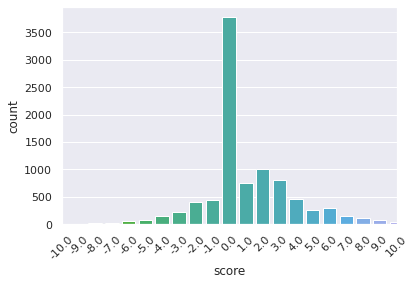

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="score", data=tweets_df)
ax.set_xlim([10, 30])
plt.xticks(rotation = 45)

In [ ]:
#drop all unnecessary columns, text, lat, long, city, country/country_code

tweets_df.drop(columns=['text', 'Latitude', 'Longitude', 'city', 'country', 'country_code', 'month', 'clean_text'], inplace = True)
tweets_df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


tweet_id                 date                 state  score
4      1347280195502415875  2021-01-07 20:33:24               Florida    0.0
7      1368323414835015682  2021-03-06 22:11:38               Florida    0.0
18     1345762419969302529  2021-01-03 16:02:18            Washington    0.0
21     1314944637602164736  2020-10-10 15:03:26           Mississippi    2.0
22     1325851188156313601  2020-11-09 17:22:11              New York    0.0
...                    ...                  ...                   ...    ...
18158  1363145146867601408  2021-02-20 15:15:03  District of Columbia    0.0
18160  1372320915636289536  2021-03-17 22:56:17            California    4.0
18163  1377251672225894408  2021-03-31 13:29:21              Oklahoma   -1.0
18165  1351335739028631559  2021-01-19 01:08:41               Alabama   -2.0
18167  1347677666053292033  2021-01-08 22:52:48              New York    3.0

[9220 rows x 4 columns]

In [ ]:
#fix the date format
final_df = tweets_df

In [ ]:
#now fix the date
final_df['date'] = final_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
final_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


tweet_id        date                 state  score
4      1347280195502415875  2021-01-07               Florida    0.0
7      1368323414835015682  2021-03-06               Florida    0.0
18     1345762419969302529  2021-01-03            Washington    0.0
21     1314944637602164736  2020-10-10           Mississippi    2.0
22     1325851188156313601  2020-11-09              New York    0.0
...                    ...         ...                   ...    ...
18158  1363145146867601408  2021-02-20  District of Columbia    0.0
18160  1372320915636289536  2021-03-17            California    4.0
18163  1377251672225894408  2021-03-31              Oklahoma   -1.0
18165  1351335739028631559  2021-01-19               Alabama   -2.0
18167  1347677666053292033  2021-01-08              New York    3.0

[9220 rows x 4 columns]

In [ ]:
#write to csv
final_df.to_csv('tweets_w_features')

## OpenTable Data Feature Engineering

### OpenTable Data Import

In [ ]:
import pandas as pd
from datetime import datetime
opentable_df = pd.read_csv('opentable.csv')
display(opentable_df.head(5))

Type       Name 2020/2/18 2020/2/19  ... 2021/4/5 2021/4/6 2021/4/7 2021/4/8
0  country     Global       -1%        3%  ...  -29.65%  -34.34%  -31.88%  -28.63%
1  country  Australia       -3%       -6%  ...  236.34%   94.41%  114.38%  124.48%
2  country     Canada       -5%        0%  ...  -71.78%  -78.27%  -76.35%  -73.34%
3  country    Germany       11%        4%  ...  -98.35%  -99.47%  -99.27%  -98.96%
4  country    Ireland        2%        0%  ...  -99.38%  -99.86%  -99.84%   -99.9%

[5 rows x 418 columns]

### Opentable Data Feature Engineering
In this section, we did the following things:
1. Select only United States Data
2. Add datetime features (Add 'year', 'month', 'week', 'dayOfWeek', 'dayOfWeek.name' and 'dayOfYear' columns).
3. Add keys for indexing based on datetime features.
4. Add lagged terms and rolling statistics.
5. One-hot encode day of the week.
6. Reorder columns.
7. Create interaction terms between features and day of the week.

**Conclusion:**
The following features should be used for the opentable dataset:
* 'lag14',
* 'lag14_dd_change',
* 'lag14_wkly_change',
* 'lag14_roll',
* 'lag14_dd_change_roll',
* 'lag14_wkly_change_roll',
* 'Friday',
* 'Monday',
* 'Saturday',
* 'Thursday',
* 'Tuesday',
* 'Wednesday',
* all interaction terms


Select only US data.

In [ ]:
# Select only United States data
opentable_df = opentable_df[opentable_df['Name'] == 'United States'].transpose()
# Drop redundant columns
opentable_df.drop(['Type', 'Name'], inplace = True)
# Convert index to datetime object
opentable_df.index = opentable_df.index.map(lambda x : datetime.strptime(x, '%Y/%m/%d'))
opentable_df.index.name = 'checkin_date'
# Rename column
opentable_df.columns = ['bizActivity']
# Cast value to float
opentable_df['bizActivity'] = opentable_df['bizActivity'].apply(lambda x : float(x[:-1]) / 100)

Add datetime features.

In [ ]:
opentable_df['year'] = opentable_df.index.map(lambda x : int(str(x)[0:4])) # x.year generated 1's
opentable_df['month'] = opentable_df.index.map(lambda x : x.month)
opentable_df['week'] = opentable_df.index.map(lambda x : x.isocalendar()[1])
opentable_df['dayOfWeek'] = opentable_df.index.map(lambda x : x.weekday)
opentable_df['dayOfWeek.name'] = opentable_df.index.map(lambda x : x.strftime("%A"))
opentable_df['dayOfYear'] = opentable_df.index.map(lambda x : x.timetuple().tm_yday)

Add keys for indexing based on datetime features.

In [ ]:
opentable_df['_key1'] = opentable_df.apply(lambda x : str(int(x['year'])) + '.' + str(f"{int(x['dayOfYear']):03d}"), axis = 1)
opentable_df['_key2'] = opentable_df.apply(lambda x : str(f"{int(x['week']):02d}") + '.' + str(f"{int(x['dayOfWeek']):02d}"), axis = 1)
opentable_df['_key3'] = opentable_df.apply(lambda x : str(int(x['year'])) + '.' + str(f"{int(x['week']):02d}"), axis = 1)

Add lagged terms and rolling statistics.

In [ ]:
# lag14
lag14 = pd.Series(opentable_df['bizActivity'].shift(14), name = 'lag14')

# lag14 daily change
# (i.e. if we are on Monday, what was the difference from Sunday to Monday two weeks ago?)
lag14_dd_change = pd.Series(lag14.diff(), name = 'lag14_dd_change')

# lag1 weekly change
# (i.e. if we are on Tuesday, what was the difference from Monday of three weeks ago to last Monday?)
lag14_wkly_change = pd.Series(lag14.diff(7), name = 'lag14_wkly_change')

# lag1 rolling weekly average
# (i.e. if we are on Tuesday, what was the average value from Tuesday of last week through this Monday (yesterday)?)
lag14_roll = pd.Series(pd.Series.rolling(lag14, center = False, window = 7).mean(), name = 'lag14_roll')

# daily_change rolling weekly average
lag14_dd_change_roll = pd.Series(pd.Series.rolling(lag14_dd_change, center = False, window = 7).mean(), name = 'lag14_dd_change_roll')

# weekly_change rolling weekly average
lag14_wkly_change_roll = pd.Series(pd.Series.rolling(lag14_wkly_change, center = False, window = 7).mean(), name = 'lag14_wkly_change_roll')

# concatenate
opentable_df = pd.concat([opentable_df, lag14, lag14_dd_change, lag14_wkly_change,
                          lag14_roll, lag14_dd_change_roll, lag14_wkly_change_roll],
                          axis = 1).dropna()

One-hot encode day of the week.

In [ ]:
# week day dummies
opentable_df = pd.concat([opentable_df, pd.get_dummies(opentable_df['dayOfWeek.name'])], axis = 1)
opentable_df.drop(columns = ['Sunday'], inplace = True) # Sunday will become base case (i.e. intercept)

Reorder columns.

In [ ]:
colOrder = ['_key1',
            '_key2',
            '_key3',
            'bizActivity',
            'year',
            'month',
            'week',
            'dayOfWeek',
            'dayOfWeek.name',
            'dayOfYear',
            'lag14',
            'lag14_dd_change',
            'lag14_wkly_change',
            'lag14_roll',
            'lag14_dd_change_roll',
            'lag14_wkly_change_roll',
            'Monday',
            'Tuesday',
            'Wednesday',
            'Thursday',
            'Friday',
            'Saturday']

opentable_df = opentable_df[colOrder]

Create interaction terms between features and day of the week.

In [ ]:
attr_init = int(pd.DataFrame((opentable_df.columns == 'lag14')).idxmax())
attr_end = int(pd.DataFrame((opentable_df.columns == 'lag14_wkly_change_roll')).idxmax()) + 1
day_init = int(pd.DataFrame((opentable_df.columns == 'Friday')).idxmax())
for m in range(attr_init, attr_end):
  for day in range(day_init, day_init + 6):
    colName = opentable_df.columns[m] + ':' + opentable_df.columns[day]
    opentable_df[colName] = pd.Series(opentable_df[opentable_df.columns[m]] * opentable_df[opentable_df.columns[day]], name = colName)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
opentable_df.head(10)

_key1  ... lag14_wkly_change_roll:lag14:lag14:Saturday
checkin_date            ...                                            
2020-03-16    2020.076  ...                                   -0.000000
2020-03-17    2020.077  ...                                   -0.000000
2020-03-18    2020.078  ...                                   -0.000000
2020-03-19    2020.079  ...                                   -0.000000
2020-03-20    2020.080  ...                                   -0.000000
2020-03-21    2020.081  ...                                   -0.000058
2020-03-22    2020.082  ...                                   -0.000000
2020-03-23    2020.083  ...                                   -0.000000
2020-03-24    2020.084  ...                                   -0.000000
2020-03-25    2020.085  ...                                   -0.000000

[10 rows x 58 columns]

In [ ]:
opentable_df.to_csv('opentable_w_features.csv')


## Final Data Set Generation
Here, we combine different data sources and generate one final dataset which will be used for training and testing.

###Pandasql Package Installation

In [ ]:
!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-cp37-none-any.whl size=26820 sha256=38e5662980f02784c252579e360b1c233a5f31bf80d0b7283ae5a91f6dc2eb31
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [ ]:
import pandas as pd
import pandasql as ps
#SQL on Pandas Dataframe
from datetime import datetime

### Download all source CSV files
The sources files are as following:
1.   tweets_w_features.csv
2.   opentable_w_features.csv
3.   labels.csv



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
tweets_df = pd.read_csv("/content/drive/My Drive/545finalproject/feature_engineering/tweets_w_features.csv")
opentable_df = pd.read_csv("/content/drive/My Drive/545finalproject/feature_engineering/opentable_w_features.csv")
#https://github.com/owid/covid-19-data/tree/master/public/data/. link to cases dataset
cases_df = pd.read_csv("/content/drive/My Drive/545finalproject/feature_engineering/labels.csv")

### Construct final data set
We construct the final dataframe/CSV file with the following steps:


1.   For the covid cases dataset, find the U.S. case report first and project the date and new_cases columns. We only wish to predict new_cases, not death
2.   Join tweets dataset with open-table dataset by date.
3.   Drop some columns. To be specific, the drop list comprises of 'tweet_id', 'date', 'checkin_date', '_key1', '_key2', '_key3', 'year', 'month', 'week', 'dayOfWeek' and 'dayOfYear'.
4.   Do one-hot encoding for the weekday, drop the original weekday field.

We drop these columns for different reasons:
* It may contain useless information (ex. tweet_id).
* It may contains duplicate information that already exists in existing columns (ex. date, checkin_date, year, month, week, dayOfWeek and dayOfYear).
* It may be the column that is generated when doing the join and contains no useful/meaning info by itself (ex. _key1, _key2 and _key3).






In [ ]:
tweets_df['new_date'] = tweets_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d') + pd.DateOffset(days = 1))
tweets_df.drop(columns= {'date'}, inplace = True);
tweets_df.rename(columns= {'new_date': 'date'}, inplace = True)
tweets_df['date'] = tweets_df['date'].apply(lambda x : str(x)[0:10])
display(tweets_df.head(2))

Unnamed: 0             tweet_id    state  score        date
0           4  1347280195502415875  Florida    0.0  2021-01-08
1           7  1368323414835015682  Florida    0.0  2021-03-07

In [ ]:
#tidy up the cases data set
cases_df = cases_df[cases_df['location'] == 'United States'][['date', 'new_cases']]
cases_df

date  new_cases
79926  2020-01-22        NaN
79927  2020-01-23        0.0
79928  2020-01-24        1.0
79929  2020-01-25        0.0
79930  2020-01-26        3.0
...           ...        ...
80382  2021-04-22    67257.0
80383  2021-04-23    62399.0
80384  2021-04-24    53363.0
80385  2021-04-25    32065.0
80386  2021-04-26    47691.0

[461 rows x 2 columns]

In [ ]:
#join tweets with open table
query = ''' SELECT * FROM tweets_df t JOIN opentable_df o ON t.date = o.checkin_date'''

tweets_opentable_df = ps.sqldf(query, locals())

tweets_opentable_df = tweets_opentable_df.loc[:, ~tweets_opentable_df.columns.str.contains('^Unnamed')]

tweets_opentable_df


tweet_id  ... lag14_wkly_change_roll:Wednesday
0     1347280195502415875  ...                         0.000000
1     1368323414835015682  ...                         0.000000
2     1345762419969302529  ...                         0.000000
3     1314944637602164736  ...                         0.000000
4     1325851188156313601  ...                         0.000000
...                   ...  ...                              ...
9215  1363145146867601408  ...                         0.000000
9216  1372320915636289536  ...                         0.000000
9217  1377251672225894408  ...                         0.000000
9218  1351335739028631559  ...                         0.133357
9219  1347677666053292033  ...                         0.000000

[9220 rows x 63 columns]

In [ ]:
#attach the labels (cases). Only care about cases, not deaths
query = '''SELECT * FROM tweets_opentable_df t JOIN cases_df c ON t.date = c.date'''

final_df = ps.sqldf(query, locals())
final_df.drop(columns = ['tweet_id'], inplace = True)
final_df

state  score  ...        date new_cases
0                  Florida    0.0  ...  2021-01-08  295215.0
1                  Florida    0.0  ...  2021-03-07   41007.0
2               Washington    0.0  ...  2021-01-04  184282.0
3              Mississippi    2.0  ...  2020-10-11   45941.0
4                 New York    0.0  ...  2020-11-10  140496.0
...                    ...    ...  ...         ...       ...
9215  District of Columbia    0.0  ...  2021-02-21   57080.0
9216            California    4.0  ...  2021-03-18   60538.0
9217              Oklahoma   -1.0  ...  2021-04-01   79045.0
9218               Alabama   -2.0  ...  2021-01-20  183236.0
9219              New York    3.0  ...  2021-01-09  260695.0

[9220 rows x 64 columns]

In [ ]:
final_df.drop(columns = ['date', 'checkin_date', '_key1', '_key2', '_key3',
                          'year', 'month', 'week', 'dayOfWeek', 'dayOfYear', 'bizActivity', 'dayOfWeek.name'], inplace = True)
final_df

state  score  ...  lag14_wkly_change_roll:Wednesday  new_cases
0                  Florida    0.0  ...                          0.000000   295215.0
1                  Florida    0.0  ...                          0.000000    41007.0
2               Washington    0.0  ...                          0.000000   184282.0
3              Mississippi    2.0  ...                          0.000000    45941.0
4                 New York    0.0  ...                          0.000000   140496.0
...                    ...    ...  ...                               ...        ...
9215  District of Columbia    0.0  ...                          0.000000    57080.0
9216            California    4.0  ...                          0.000000    60538.0
9217              Oklahoma   -1.0  ...                          0.000000    79045.0
9218               Alabama   -2.0  ...                          0.133357   183236.0
9219              New York    3.0  ...                          0.000000   260695.0

[9220 rows x 51 columns]

Our final dataset shape will be (9220, 51).
<br>We have 9220 instances with 51 features.

In [ ]:
final_df.shape

(9220, 51)

In [ ]:
#write to csv
final_df.to_csv('features_and_labels.csv')

# Exploratory Data Analysis

In [ ]:
import json
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

## Helper Function
* Function to transfer the state from abbreviations to the state's full name
* Function to drop non_numeric_cols in Pandas DataFrame
* Function to do covariance analysis of data

In [ ]:
##
## Helper function 0: Standard the city name
##
def standard_city_name(df):
  df['city_name'] = df['city'].apply(lambda x: x.title() if x!=None else x);
  df = df.drop(columns = ['city'])
  df.rename(columns = {'city_name': 'city'}, inplace = True)
  return df;

##
## Helper function 1: translate the state abbreviation to the state full name
## param: state abbrevations
## return: state full name
##
def transfer_state_from_abbre_to_name(state_abbre):
    states = {
            'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa',
            'AZ': 'Arizona','CA': 'California','CO': 'Colorado',
            'CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware',
            'FL': 'Florida','GA': 'Georgia','GU': 'Guam','HI': 'Hawaii',
            'IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana',
            'KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','MA': 'Massachusetts',
            'MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota',
            'MO': 'Missouri','MP': 'Northern Mariana Islands', 'MS': 'Mississippi',
            'MT': 'Montana','NC': 'North Carolina',
            'ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire',
            'NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada',
            'NY': 'New York', 'OH': 'Ohio','OK': 'Oklahoma',
            'OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico',
            'RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota',
            'TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VA': 'Virginia',
            'VI': 'Virgin Islands', 'VT': 'Vermont','WA': 'Washington',
            'WI': 'Wisconsin','WV': 'West Virginia', 'WY': 'Wyoming',
            ## non-us state
            'BC':'British Columbia', 'ABE':'British Columbia',
            'ON':'British Columbia'
    }
    if  state_abbre not in states.keys():
      print(state_abbre)
      return "unknown state";
    else:
      return states[state_abbre];
##
## Helper function 2: Drop non numeric cols of dataframe
## param df: pandas dataframe
## return: new dataframe with only numeric columns
##
def drop_non_numeric_cols(df):
  non_numeric_cols = []
  for col in df.columns:
      if df[col].dtypes != "float64" and df[col].dtypes != "int64":
          non_numeric_cols.append(col)
  df = df.drop(columns=non_numeric_cols)
  return df;

##
## Helper function 3: covariance matrix
## param df: original pandas df
## param fig_size: default (8,8)
## params title: title of the figure, default "Covariane Matrix Analysis"
## return: nothing
##
def covariance_matrix_analysis(df, fig_size= (8,8), title = "Covariance Matrix Analysis"):
  # need to drop cols that are not number
  df = drop_non_numeric_cols(df);
  df_scaled = df.copy();
  # get all columns
  cols= list(df.columns.values);
  # scale down the data
  standard_scaler = preprocessing.StandardScaler()
  scaled_values = standard_scaler.fit_transform(df_scaled);
  df_scaled.loc[:,:] = scaled_values;
  # get the covariance matrix
  cov_mat =np.cov(df_scaled.T)
  ############ Graphing ############
  plt.figure(figsize=fig_size)
  sns.set(font_scale=1)
  hm = sns.heatmap(cov_mat,cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15},
                 yticklabels=cols, xticklabels=cols)
  plt.title(title)
  plt.tight_layout()
  plt.show()

## Yelp Dataset EDA


*   Convert Yelp data from JSON string to pandas object.
*   Data Size and Type Conclusion
*   Correlation Matrix Analysis
*   Interesting Queries and Visualization
*   Decompose certain field and information extraction  




Here, we create the yelp data frame using the following steps:
1. load two json files as Pandas dataframe. These two files are  "yelp_academic_dataset_business.json" "yelp_academic_dataset_checkin.json" file.
2. We combine these two dataframes by joining on the 'business_id' field.  

In [ ]:
# import JSON parsing
yelp_business_df = pd.read_json('yelp_academic_dataset_business.json', lines = True)
yelp_checkin_df = pd.read_json('yelp_academic_dataset_checkin.json', lines = True)
# merge these two dataset by the business id
yelp_df = pd.merge(left= yelp_business_df, right = yelp_checkin_df, left_on = 'business_id', right_on = 'business_id')
# then stardard the city name
yelp_df = standard_city_name(yelp_df)

State Exploration

In [ ]:
bt_df = yelp_df.copy()
bt_df["state_full_name"] = bt_df["state"].apply(lambda x: transfer_state_from_abbre_to_name(x));
# check
display(bt_df[bt_df['state'] == 'ABE'])
display(bt_df[bt_df['state'] == 'ON'])
display(len(bt_df[bt_df['state'] == 'BC']))

business_id  ...   state_full_name
111715  WaD_wuvvDFPTrz8ouDPtAw  ...  British Columbia

[1 rows x 16 columns]

business_id       name  ...     city   state_full_name
54214  0_4ThmueNk_fGd2TcykDeQ  Hot Topic  ...  Burnaby  British Columbia

[1 rows x 16 columns]

15982

In [ ]:
display(yelp_df.head(2))

business_id  ...      city
0  6iYb2HFDywm3zjuRg0shjw  ...   Boulder
1  tCbdrRPZA0oiIYSmHG3J0w  ...  Portland

[2 rows x 15 columns]

### Yelp DataFrame Data Conclusion

*  Column Information Check
*  Data size conclusion
1. There are 160585 entries in the yelp business dataframe.
2. There are 138876 entries in the yelp checkin dataframe.  
3. There are 138876 entries in the combined yelp dataframe.


In [ ]:
# display the column information of yelp business df
yelp_business_df.info(verbose = True);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160585 entries, 0 to 160584
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   160585 non-null  object 
 1   name          160585 non-null  object 
 2   address       160585 non-null  object 
 3   city          160585 non-null  object 
 4   state         160585 non-null  object 
 5   postal_code   160585 non-null  object 
 6   latitude      160585 non-null  float64
 7   longitude     160585 non-null  float64
 8   stars         160585 non-null  float64
 9   review_count  160585 non-null  int64  
 10  is_open       160585 non-null  int64  
 11  attributes    145593 non-null  object 
 12  categories    160470 non-null  object 
 13  hours         133244 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 17.2+ MB


In [ ]:
# display the column information of yelp checkin df
yelp_checkin_df.info(verbose = True);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138876 entries, 0 to 138875
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  138876 non-null  object
 1   date         138876 non-null  object
dtypes: object(2)
memory usage: 2.1+ MB


In [ ]:
# display the merge yelp df
yelp_df.info(verbose= True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138876 entries, 0 to 138875
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   138876 non-null  object 
 1   name          138876 non-null  object 
 2   address       138876 non-null  object 
 3   state         138876 non-null  object 
 4   postal_code   138876 non-null  object 
 5   latitude      138876 non-null  float64
 6   longitude     138876 non-null  float64
 7   stars         138876 non-null  float64
 8   review_count  138876 non-null  int64  
 9   is_open       138876 non-null  int64  
 10  attributes    128713 non-null  object 
 11  categories    138833 non-null  object 
 12  hours         116407 non-null  object 
 13  date          138876 non-null  object 
 14  city          138876 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 17.0+ MB


### Covariance Matrix Analysis


*   $\textbf{Only do the correlation analysis for numeric columns}$
<br> It only makes sense to find the relations between numerical values.  
There are 5 numeric fields in the yelp dataset: 'latitude', 'longitude', 'stars', 'review_count' and 'is_open'.
*   $\textbf{Pairwise Input Feature Correlations Exploration}$
<br>Conclusion: We can see there is no strong correlations between 'latitude', 'longitude', 'stars', 'review_count' and 'is_open'. We do not need to do PCA.




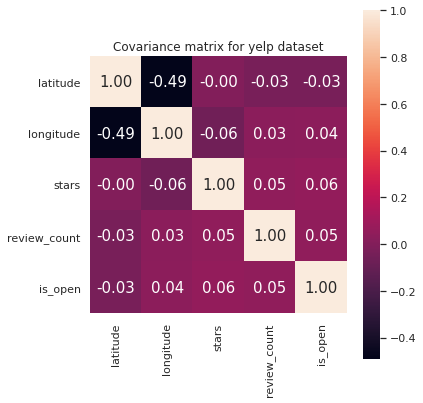

In [ ]:
covariance_matrix_analysis(yelp_df, (6,6), "Covariance matrix for yelp dataset")

### Geographical Data Visualization
Since there is geographical information ('latitude' and 'longitude' fields) in our dataset, we'll try visualizing using a map!

*   Download the relevant pkg for the Basemap
*   Mark data on the map!



#### Download the relevant packages for the BaseMap

In [ ]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
from mpl_toolkits.basemap import Basemap

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
     | 149.2MB 1.8MB/s
     |████████████████████████████████| 225kB 17.2MB/s 
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759566 sha256=ead97409ef1eff8a265de95e7aed6249a2b92c498df262f058ece4dd5f0f4e07
  Stored in directory: /tmp/pip-ephem-wheel-cache-9o96ilj_/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl size=37264 sha256=8703d3bf6f199f2742eafe4d52a9864c7f2fe

#### Helper function to draw the geomap
Ref: https://makersportal.com/blog/2018/7/20/geographic-mapping-from-a-csv-file-using-python-and-basemap

In [ ]:
def draw_geographical_graph(lats, lons, zoom_scale_lats = 20,  zoom_scale_lons = 2, title= "Map"):
  # How much to zoom from coordinates (in degrees)
  # Setup the bounding box for the zoom and bounds of the map
  bbox = [np.min(lats)-zoom_scale_lats,np.max(lats)+zoom_scale_lats,\
          np.min(lons)-zoom_scale_lons,np.max(lons)+zoom_scale_lons]

  plt.figure(figsize=(12,40))
  # draw parallels, meridians, and color boundaries
  # Define the projection, scale, the corners of the map, and the resolution.
  m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
              llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

  # Draw coastlines and fill continents and water with color
  m.drawcoastlines()
  m.fillcontinents(color='peru',lake_color='dodgerblue')

  # draw parallels, meridians, and color boundaries
  m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/10),labels=[1,0,0,0])
  m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/10),labels=[0,0,0,1],rotation=45)
  m.drawmapboundary(fill_color='dodgerblue')

  # build and plot coordinates onto map
  x,y = m(lons,lats)
  m.plot(x,y,'r*',markersize=5)
  plt.title(title)
  png_name = title+".png"
  plt.savefig(png_name, format='png', dpi=500)
  plt.show()

#### Draw the map for yelp data

Since there are 'latitude' and 'longitude' fields in this dataset, we mark the data points in a real geographical map.
<br>Each red point in the map corresponds to one data point.  

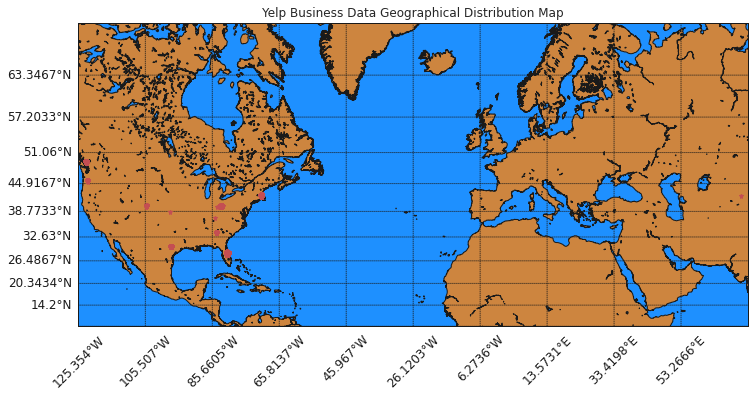

In [ ]:
lats = list(yelp_df['latitude'])
lons= list(yelp_df['longitude'])
title = "Yelp Business Data Geographical Distribution Map"
zoom_scale_lats = 20;
zoom_scale_lons = 2;
draw_geographical_graph(lats, lons, zoom_scale_lats, zoom_scale_lons, title)

### Interesting Queries & Visualization

#### Top 10 State & Top 10 City by business
---
**Movitation:**  We are curious about which state or which city will have the maximum number of businesses
<br>**Conclusion:** The top 10 states/provinces with most businesses in the dataset are Massachusettes, Oregon, Florida, Texas, Georgia, British Columbia, Ohio, Washington, Colorado and California.
The top 10 cities with the most businesses are Austin, Portland, Vaconver, Atlanda, Orlando, Boston, Columbus, Cambridge, Boulder and Beaverton.    

**Data Aggregation steps:**
1. Aggregrate by state/city
2. Order the result by business_count (descending order)
3. Find the top 10 states/cities

**Plotting steps:**
1. Set the title
2. Set seaborn theme
3. Do the plot by seaborn barplot
4. Rotate the ticks of x axis to better visualization

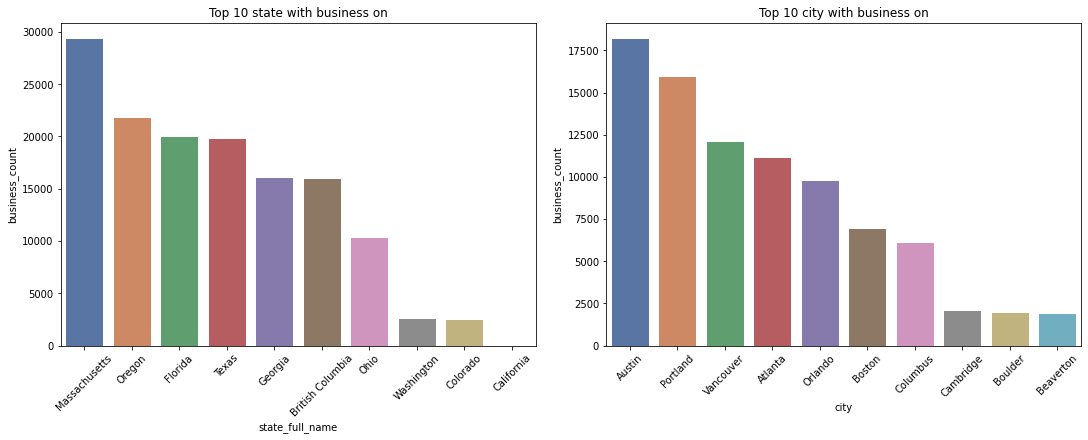

In [ ]:
################### business per state ##########################
business_per_state = yelp_df[['state', 'business_id']].groupby('state').count().reset_index().rename(columns={'business_id': 'business_count'});
sorted_business_per_state = business_per_state.sort_values(by = ['business_count', 'state'], ascending= False)
# only select state that has most business on
popular_business_per_state = sorted_business_per_state.head(10)
# add the full name of the state for better understanding
popular_business_per_state_full_name = popular_business_per_state.copy()
popular_business_per_state_full_name["state_full_name"] = popular_business_per_state["state"].apply(lambda x: transfer_state_from_abbre_to_name(x));

################## business per city #######################
business_per_city = yelp_df[['city', 'business_id']].groupby('city').count().reset_index().rename(columns={'business_id': 'business_count'});
popular_business_per_city = business_per_city.sort_values(by = ['business_count','city'], ascending= False).head(10)

######################### GRAPH #####################################
state_graph_title = "Top 10 state with business on"
city_graph_title = "Top 10 city with business on"
fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

# state business conclusion figure
axs[0].set_title(state_graph_title)
sns.set_theme(style="whitegrid")
ax1 = sns.barplot(ax=axs[0], x = popular_business_per_state_full_name.state_full_name,
                 y=popular_business_per_state_full_name.business_count);
ax1.tick_params(axis='x', rotation=45)

# city business conclusion figure
axs[1].set_title(city_graph_title)
sns.set_theme(style="whitegrid")
ax2 = sns.barplot(ax=axs[1], x = popular_business_per_city.city,
                 y = popular_business_per_city.business_count);
ax2.tick_params(axis='x', rotation=45)

#### Cities/State people like to review
---
**Motivation:**  We are curious which states and cities have the most reviews.
<br>**Conclusion:** If the scope of this question is limited to state, we can see that people living in Georgia, Texas and Massachusetts are most likely to review businesses
If the scope of this question is limited to cities, we can see that people living in Boston and Cambridge are most likely to review businesses.   

<br>**Data Aggregation steps:**
1. Aggregrate by state/city
2. Order the result by review_sum (descending order)
3. Find the top 10 state/city with most reviews
4. Find all records within these cities/states

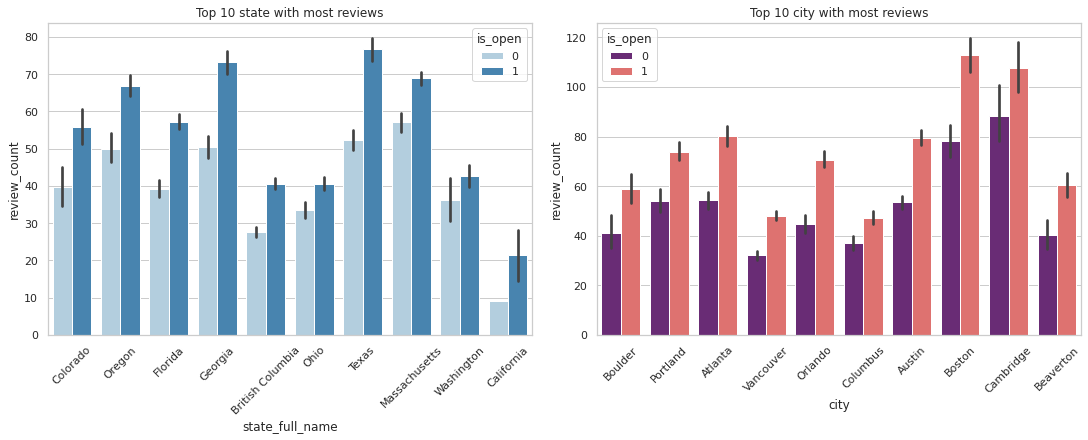

In [ ]:
################### reviews per state ##########################
reviews_per_state = yelp_df[['state', 'review_count']].groupby('state').sum().reset_index();
sorted_reviews_per_state = reviews_per_state.sort_values(by = ['review_count', 'state'], ascending= False)
# only select state that most reviews
most_reviews_per_state = sorted_reviews_per_state.head(10)
# add the full name of the state for better understanding
most_reviews_per_state_full_name = most_reviews_per_state.copy()
most_reviews_per_state_full_name["state_full_name"] = most_reviews_per_state["state"].apply(lambda x: transfer_state_from_abbre_to_name(x));
most_reviews_states = pd.merge(left = yelp_df, right = most_reviews_per_state_full_name,
                        left_on = 'state', right_on ='state')
most_reviews_states.rename(columns={'review_count_x': 'review_count',
                                    'review_count_y': 'review_count_sum_per_state'}, inplace = True)
################### reviews per city #######################
reviews_per_city = yelp_df[['city', 'review_count']].groupby('city').sum().reset_index();
most_reviews_per_city = reviews_per_city.sort_values(by = ['review_count','city'], ascending= False).head(10)
most_reviews_cities = pd.merge(left = yelp_df, right= most_reviews_per_city,
                               left_on = 'city', right_on='city')
most_reviews_cities.rename(columns = {'review_count_x': 'review_count',
                                     'review_count_y': 'review_count_sum_per_city'}, inplace = True)
######################### GRAPH #####################################
state_gt = "Top 10 state with most reviews"
city_gt = "Top 10 city with most reviews"
fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

# state reviews conclusion figure
axs[0].set_title(state_gt)
sns.set_theme(style="whitegrid")
ax1 = sns.barplot(ax=axs[0], x = most_reviews_states.state_full_name,
                  y=most_reviews_states.review_count,
                  hue = most_reviews_states.is_open,
                  palette = 'Blues');
ax1.tick_params(axis='x', rotation=45)

# city reviews conclusion figure
axs[1].set_title(city_gt)
sns.set_theme(style="whitegrid")
ax2 = sns.barplot(ax=axs[1], x = most_reviews_cities.city,
                  y = most_reviews_cities.review_count,
                  hue= most_reviews_cities.is_open,
                  palette = 'magma');
ax2.tick_params(axis='x', rotation=45)

#### Average Stars of Restaurant Per State/City

---
**Motivation:** There is a 'star' field in the yelp dataset which indicates what people rated a business
We are curious about the states/cities where restaurants have high ratings.
<br>**Conclusion:** If the scope of this question is limited to states, We can see that restaurants in Colorado, Oregon and Florida tend to have better service.






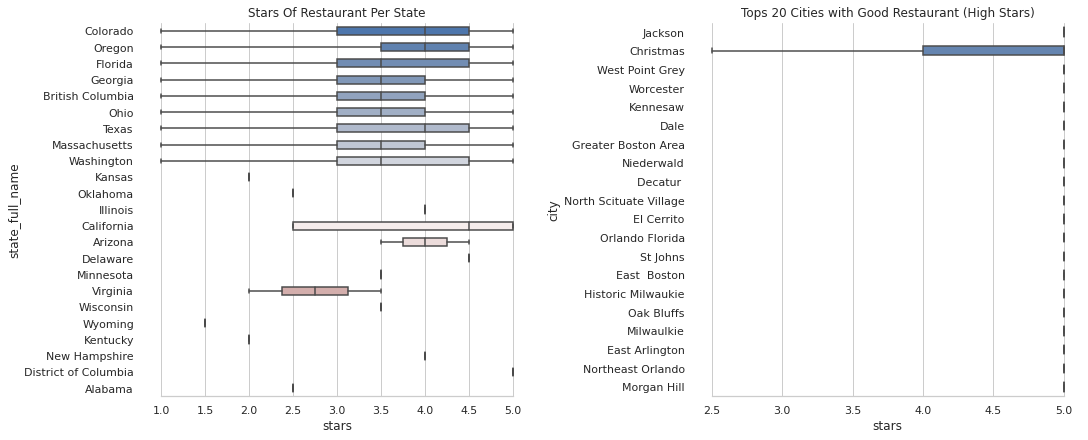

In [ ]:
stars_per_state = yelp_df[['state', 'stars']].groupby('state').median().reset_index().sort_values('stars', ascending = False)
stars = yelp_df.copy()
stars["state_full_name"] = yelp_df["state"].apply(lambda x: transfer_state_from_abbre_to_name(x))

# find top 20 cities according to the stars medians
stars_per_city = yelp_df[['city', 'stars']].groupby('city').median().reset_index().sort_values(by= ['stars', 'city'],ascending = False)
stars_city_set = set(stars_per_city.head(20)['city']);
partial_stars = stars[stars["city"].isin(stars_city_set)]
######################### GRAPH #####################################
f, axs = plt.subplots(1,2, figsize=(15, 6), constrained_layout=True)
stars_state_gtitle = "Stars Of Restaurant Per State"
stars_city_gtitle = "Tops 20 Cities with Good Restaurant (High Stars)"
axs[0].set_title(stars_state_gtitle)
axs[1].set_title(stars_city_gtitle)
sns.boxplot(ax = axs[0], x="stars", y="state_full_name", data=stars,
            whis=[0, 100], width=.5, palette="vlag")
sns.boxplot(ax = axs[1], x="stars", y="city", data= partial_stars,
            whis=[0, 100], width=.5, palette="vlag")
sns.despine(trim=True, left=True)

### Information retrieving

#### Helper function
1. function to retrieve the Monday_hours, Tuesday_hours, Wednesday_hours,
Thursday_hours, Friday_hours, Saturday_hours, Sunday_hours

In [ ]:
d= {'Monday': 'Monday_hours',
      'Tuesday': 'Tuesday_hours',
      'Wednesday': 'Wednesday_hours',
      'Thursday':'Thursday_hours',
      'Friday':'Friday_hours',
      'Saturday': 'Saturday_hours',
      'Sunday':'Sunday_hours'
}

def get_all_categories(df):
  categories_set = set()
  df['categories'].apply(lambda x: categories_set.update(x.split(",")) if x!=None else x)
  return categories_set

def extract_working_hours_by_day(df):
  for spec_day in d.keys():
    spec_day_attr = d[spec_day];
    df[spec_day_attr] = df['hours'].apply(lambda x: x[spec_day] if x!=None and spec_day in x.keys() else None)
  # drop the original hours column
  df.drop(columns = ['hours'], inplace = True);

def get_business_sum_for_different_weekday(df):
  mapping = {'week_day':[], 'business_sum':[]};
  for spec_day in d.keys():
    attr = d[spec_day]
    day_df = df.dropna(subset=[attr])
    day_df = day_df[['business_id', attr]]
    count_of_spec_weekday_df = day_df.groupby('business_id').count().reset_index()
    count_of_spec_weekday = np.sum(count_of_spec_weekday_df[attr])
    mapping['week_day'].append(spec_day)
    mapping['business_sum'].append(count_of_spec_weekday)
  return pd.DataFrame(mapping)


#### Business amount change during a week.
**Motivation:** Although we know the daily bussiness amount, we are curious about on which day of the week (Monday, Tuesday, Wednesday ...) has the most business activity

**Conclusion:**
*   There is more business activity on Friday
*   The business activity on Sunday is the smallest.
<br> This is understandable as many businesses are closed on Sunday.  



[Text(0.05, 103772, '105772'),
 Text(1.05, 108572, '110572'),
 Text(2.05, 111028, '113028'),
 Text(3.05, 112241, '114241'),
 Text(4.05, 111910, '113910'),
 Text(5.05, 100055, '102055'),
 Text(6.05, 75391, '77391')]

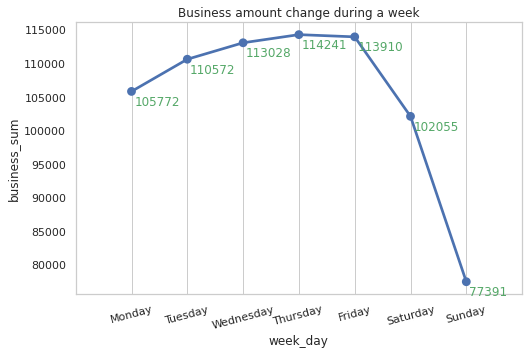

In [ ]:
yelp_copy = yelp_df.copy();
extract_working_hours_by_day(yelp_copy);
business_count_per_weekday_df = get_business_sum_for_different_weekday(yelp_copy);
######################### GRAPH #####################################
plt.figure(figsize=(8, 5));
ax = sns.pointplot(data= business_count_per_weekday_df,  x= 'week_day', y='business_sum');
ax.set_title("Business amount change during a week")
ax.set_xlim([-1, 7]);
ax.grid();
ax.set_xticks(np.arange(0, 7, 1));
ax.tick_params(axis='x', rotation=15)
business_counts = list(business_count_per_weekday_df['business_sum'])
[ax.text(p[0]+0.05, p[1]-2000, p[1], color='g') for p in zip(ax.get_xticks(), business_counts)]

#### Business amount change with months
**Movitation:** We are curious about the monthly business activity change since the pandemic began

**Procedure:** Check the business activity change per month starting from 2010-07 to 2020-04.

**Conclusion:** Starting from 2011, the business activity per month is decreasing generally.


In [ ]:
checkin_count_dict = {};
def add_checkin_count(date):
  if date== None:
    return;
  l = date.split(",")
  for value in l:
    # extract the date from the timestamp
    value = value.split(" ")[0]
    value = value[0:7]
    if "-" not in value:
      continue;
    if value not in checkin_count_dict.keys():
      checkin_count_dict[value]= 0;
    checkin_count_dict[value] = checkin_count_dict[value]+1;

def extract_month_info(df):
  df['date'].apply(lambda x: add_checkin_count(x))
  checking_mapping = {'spec_month': [], 'business_count':[]}
  for spec_month in checkin_count_dict.keys():
    count = checkin_count_dict[spec_month]
    checking_mapping['spec_month'].append(spec_month);
    checking_mapping['business_count'].append(count);
    df = pd.DataFrame(checking_mapping);
    df.dropna(subset = ['spec_month'], inplace= True)
  return df


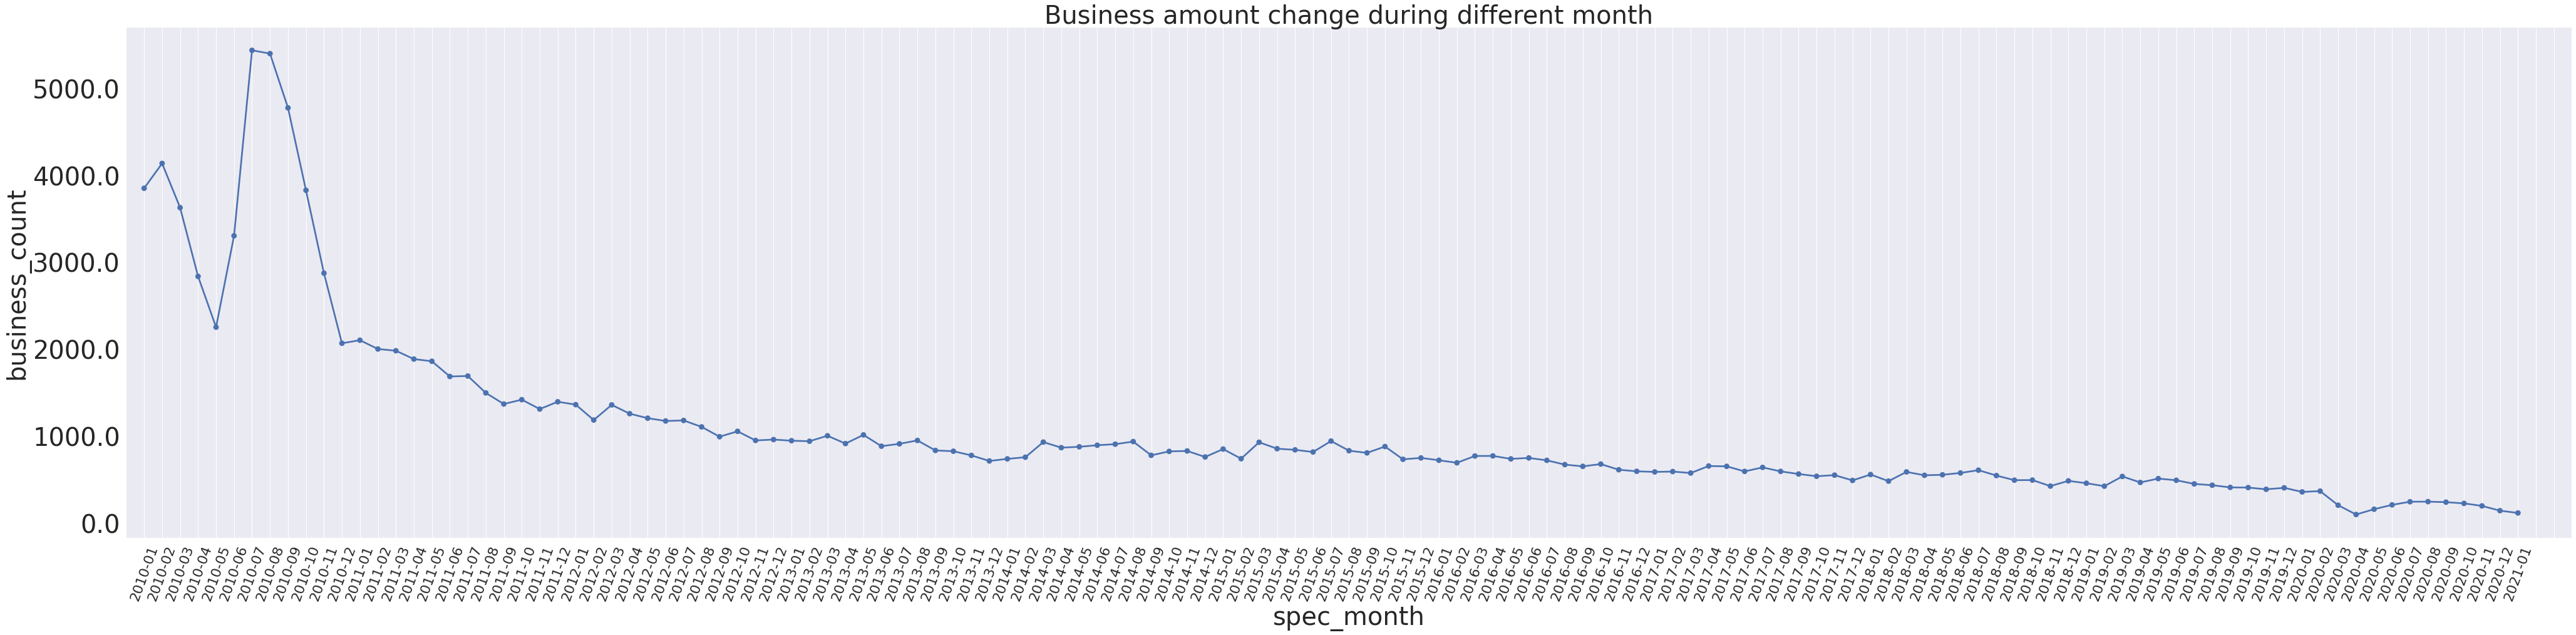

In [ ]:
yelp_copy = yelp_df.copy();
business_count_per_month_df = extract_month_info(yelp_copy)
business_count_per_month_df = business_count_per_month_df.sort_values(by = 'spec_month', ascending=True)
######################### GRAPH #####################################
plt.figure(figsize=(70, 15));
sns.set(font_scale=2)
ax = sns.pointplot(data= business_count_per_month_df,  x= 'spec_month', y='business_count');
ax.axes.set_title("Business amount change during different month",fontsize=40)
ax.set_xlabel("spec_month",fontsize=40)
ax.set_ylabel("business_count",fontsize=40)
ax.set_yticklabels(ax.get_yticks(), size=40)
ax.set_xlim([-1, 135]);
ax.grid();
ax.set_xticks(np.arange(0, 135, 1));
ax.tick_params(axis='x', rotation=70)

#### Business amount change during recent days
**Motivation:** Although we can know the monthly business amount change, we may care more about business activity change in a more recent time period.

**Procedures:** Check the business activity change per month starting from 2020-10-01 to now.(2021-01-28)

**Conclusion:** We can see that daily business activity changes a lot. Generally the monthly business amount is decreasing, there is volatility between days



In [ ]:
checkin_day_count_dict = {};
def add_recent_day_checkin_count(date):
  if date== None:
    return;
  l = date.split(",")
  for value in l:
    # extract the date from the timestamp
    value = value.split(" ")[0]
    if "-" not in value or value < "2020-10-01":
      continue;
    if value not in checkin_day_count_dict.keys():
      checkin_day_count_dict[value]= 0;
    checkin_day_count_dict[value] = checkin_day_count_dict[value]+1;

def extract_recent_day_info(df):
  df['date'].apply(lambda x: add_recent_day_checkin_count(x))
  checking_mapping = {'recent_date': [], 'business_count':[]}
  for spec_date in checkin_day_count_dict.keys():
    count = checkin_day_count_dict[spec_date]
    checking_mapping['recent_date'].append(spec_date);
    checking_mapping['business_count'].append(count);
    df = pd.DataFrame(checking_mapping);
    df.dropna(subset = ['recent_date'], inplace= True)
  return df

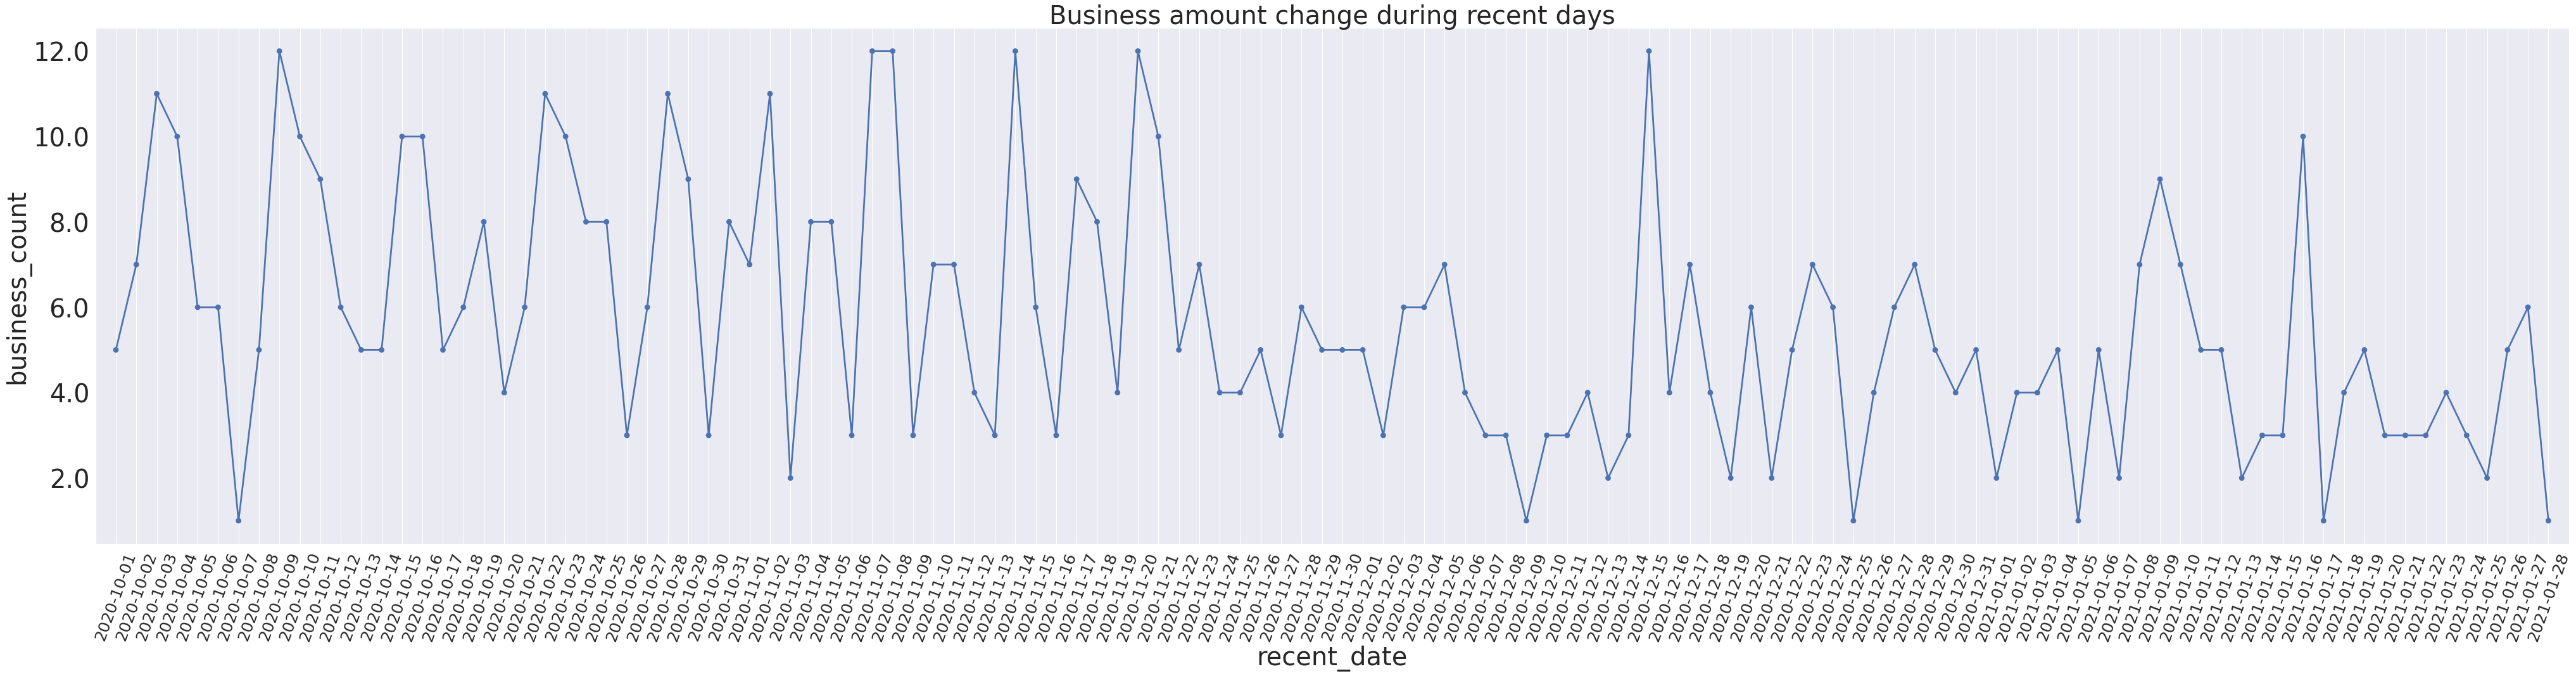

In [ ]:
yelp_copy = yelp_df.copy();
business_count_recent_day_df = extract_recent_day_info(yelp_copy)
business_count_recent_day_df = business_count_recent_day_df.sort_values(by = 'recent_date', ascending=True)
######################### GRAPH #####################################
plt.figure(figsize=(70, 15));
sns.set(font_scale=2.3)
ax = sns.pointplot(data= business_count_recent_day_df,  x= 'recent_date', y='business_count');
ax.axes.set_title("Business amount change during recent days",fontsize=40)
ax.set_xlabel("recent_date",fontsize=40)
ax.set_ylabel("business_count",fontsize=40)
ax.set_yticklabels(ax.get_yticks(), size=40)
l = len(business_count_recent_day_df)
ax.set_xlim([-1, l]);
ax.set_xticks(np.arange(0, l, 1));
ax.tick_params(axis='x', rotation=70)
ax.grid();

## Opentable Dataset EDA
**Introduction:** Opentable is a dataset that describes the business activity at restauarants from 2019 onwards
<br>This dataset highlights how creative restaurants have gotten over the past year by increasing their outdoor seating in order to reducing their wait times, meaning they can seat more guests.

**In this section, we will do the following things:**
*   Convert Opentable data from csv file to pandas object.
*   Transpose the dataframe
*   Data Size and Type Conclusion
*   Correlation Matrix Analysis
*   Interesting Queries and Visualization
*   Decompose certain field and information extraction  


### Helper function


In [ ]:
import datetime
def set_first_row_as_head(df):
  # set the first row as the header
  type_header = df.iloc[0]
  name_header = df.iloc[1]
  header = [];
  l = len(type_header)
  for i in range(l):
    if type_header[i]== 'city':
      header.append('City'+'_'+ name_header[i])
      continue
    if type_header[i]== 'country':
      header.append(name_header[i])
      continue
    else:
      header.append('State'+ "_"+ name_header[i])
      continue
  # take the rest of your data minus the header row
  df = df[2:]
  # set the header row as the df header
  df.columns = header
  return df

def transform_str_to_float(num_str):
  if(type(num_str)== float):
    return;
  if(num_str== None):
    return num_str;
  l = len(num_str)
  num = (float)(num_str[0: l-1])
  return num

def transform_time(t_str):
  date_time_obj = datetime.datetime.strptime(t_str, '%Y/%m/%d')
  return date_time_obj

def transform_time_col(df):
  # convert the timestamp field to be a timeobj
  df['TimeObj'] = df['Timestamp'].apply(lambda x: transform_time(x))
  # move the timestamp to the first col
  time_col_name="TimeObj"
  first_col = df.pop(time_col_name)
  df.insert(1, time_col_name, first_col)
  return df

def transform_opentable_df(df):
  # transpose the data frame
  df = df.transpose();
  df = set_first_row_as_head(df)
  cols = df.columns
  final_df = df.copy()
  for col in cols:
    final_df[col] = df[col].apply(lambda x: transform_str_to_float(x))
  return final_df

def get_country_cols(cols):
  countries_cols = [];
  for col in cols:
    if col.startswith('State')== False and col.startswith('City')== False:
      countries_cols.append(col)
  return countries_cols;

def get_city_cols(cols):
  cities_cols = [];
  cities_cols.append('Timestamp')
  cities_cols.append('TimeObj')
  for col in cols:
    if col.startswith('City') == True:
      cities_cols.append(col)
  return cities_cols;

def get_state_cols(cols):
  states_cols = [];
  states_cols.append('Timestamp')
  states_cols.append('TimeObj')
  for col in cols:
    if col.startswith('State') == True:
      states_cols.append(col)
  return states_cols;


def check_data_is_consecutive(df):
  timeobjs = df['TimeObj']
  prevobj = None
  for timeobj in timeobjs:
    if prevobj == None:
      prevobj = timeobj;
    else:
      if (timeobj- prevobj).days!=1:
        return False
      prevobj = timeobj;
  return True;

### Data Loading and Information Retrieval
Here we will do the following things:
1.   Transform the data frame and make timestamp a column.
<br>Originally different timestamps will be used as columns in the dataframe which is counter-intuitive. By transforming the dataframe, we add a timestamp column.  
2.   Extract country-wide information.

In [ ]:
# load the data and display the first 5 rows
opentable_ori_df = pd.read_csv('opentable.csv')
display(opentable_ori_df.head(5))
# transpose the data frame
opentable_df = transform_opentable_df(opentable_ori_df)
# drop the rows that only contain the null records
opentable_df.dropna(inplace= True, how='all', subset= opentable_df.columns)
# separate the timestamp as a columns
opentable_df = opentable_df.reset_index().rename(columns = {'index': 'Timestamp'})
opentable_df = transform_time_col(opentable_df)
display(opentable_df.head(5))

Type       Name 2020/2/18 2020/2/19  ... 2021/4/5 2021/4/6 2021/4/7 2021/4/8
0  country     Global       -1%        3%  ...  -29.65%  -34.34%  -31.88%  -28.63%
1  country  Australia       -3%       -6%  ...  236.34%   94.41%  114.38%  124.48%
2  country     Canada       -5%        0%  ...  -71.78%  -78.27%  -76.35%  -73.34%
3  country    Germany       11%        4%  ...  -98.35%  -99.47%  -99.27%  -98.96%
4  country    Ireland        2%        0%  ...  -99.38%  -99.86%  -99.84%   -99.9%

[5 rows x 418 columns]

Timestamp    TimeObj  Global  ...  City_Tucson  City_Vancouver  City_Washington
0  2020/2/18 2020-02-18    -1.0  ...          NaN             9.0             -5.0
1  2020/2/19 2020-02-19     3.0  ...          NaN             1.0             57.0
2  2020/2/20 2020-02-20    -1.0  ...          NaN             7.0              9.0
3  2020/2/21 2020-02-21    -2.0  ...          NaN             6.0              0.0
4  2020/2/22 2020-02-22     1.0  ...          NaN             7.0              9.0

[5 rows x 130 columns]

The opentable dataset will contain data from different countries ( Australia, Canada, Germany, Ireland, Mexico, United Kingdom and United States), different states, and different cites.
<br> We only care about the country-wide information, we will **extract the country-wide information**.

In [ ]:
# extract all countries information
countries_cols = get_country_cols(opentable_df.columns)
countries_df = opentable_df[countries_cols]
display(countries_df.head(5))

Timestamp    TimeObj  Global  ...  Mexico  United Kingdom  United States
0  2020/2/18 2020-02-18    -1.0  ...    -5.0             1.0            0.0
1  2020/2/19 2020-02-19     3.0  ...    -5.0            -1.0            4.0
2  2020/2/20 2020-02-20    -1.0  ...    -4.0            -2.0            0.0
3  2020/2/21 2020-02-21    -2.0  ...    -3.0             0.0           -1.0
4  2020/2/22 2020-02-22     1.0  ...    -1.0            -1.0            2.0

[5 rows x 10 columns]

In [ ]:
# get all cities information
cities_cols = get_city_cols(opentable_df.columns)
cities_df = opentable_df[cities_cols]
l = len(cities_cols)
cities_header = [city[5:] if city.startswith('City') else city for city in cities_cols]
mapping = {};

for i in range(l):
  key = cities_cols[i]
  value = cities_header[i]
  mapping[key] = value

cities_df = cities_df.rename(columns= mapping)
display(cities_df.head(5))

Timestamp    TimeObj  Atlanta  ...  Tucson  Vancouver  Washington
0  2020/2/18 2020-02-18      6.0  ...     NaN        9.0        -5.0
1  2020/2/19 2020-02-19      9.0  ...     NaN        1.0        57.0
2  2020/2/20 2020-02-20     -5.0  ...     NaN        7.0         9.0
3  2020/2/21 2020-02-21     -5.0  ...     NaN        6.0         0.0
4  2020/2/22 2020-02-22     -3.0  ...     NaN        7.0         9.0

[5 rows x 62 columns]

In [ ]:
# get all states information
states_cols = get_state_cols(opentable_df.columns)
states_df = opentable_df.copy()[states_cols]
l = len(states_cols)
states_header = [state[6:] if state.startswith('State') else state for state in states_cols]
mapping = {};

for i in range(l):
  key = states_cols[i]
  value = states_header[i]
  mapping[key] = value

states_df.rename(columns= mapping, inplace = True)
display(states_df.head(5))

Timestamp    TimeObj  Alabama  ...  Virginia  Washington  Wisconsin
0  2020/2/18 2020-02-18    -14.0  ...       6.0         9.0        3.0
1  2020/2/19 2020-02-19      7.0  ...      58.0         8.0       21.0
2  2020/2/20 2020-02-20      1.0  ...      -1.0         6.0       -1.0
3  2020/2/21 2020-02-21     -2.0  ...      -3.0         3.0       -3.0
4  2020/2/22 2020-02-22      8.0  ...       6.0         2.0       14.0

[5 rows x 62 columns]

### Opentable DataFrame Data Conclusion
*  Column Information Check
*  Data size conclusion

In [ ]:
countries_df.info(verbose= True);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       416 non-null    object        
 1   TimeObj         416 non-null    datetime64[ns]
 2   Global          416 non-null    float64       
 3   Australia       416 non-null    float64       
 4   Canada          416 non-null    float64       
 5   Germany         416 non-null    float64       
 6   Ireland         416 non-null    float64       
 7   Mexico          416 non-null    float64       
 8   United Kingdom  416 non-null    float64       
 9   United States   416 non-null    float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 32.6+ KB


In [ ]:
cities_df.info(verbose = True);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 62 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Timestamp               416 non-null    object        
 1   TimeObj                 416 non-null    datetime64[ns]
 2   Atlanta                 416 non-null    float64       
 3   Austin                  416 non-null    float64       
 4   Baltimore               416 non-null    float64       
 5   Berlin                  151 non-null    float64       
 6   Beverly Hills           151 non-null    float64       
 7   Boca Raton              151 non-null    float64       
 8   Boston                  416 non-null    float64       
 9   Brooklyn                151 non-null    float64       
 10  Calgary                 416 non-null    float64       
 11  Cambridge (US)          151 non-null    float64       
 12  Charlotte               416 non-null    float64   

In [ ]:
states_df.info(verbose= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 62 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Timestamp               416 non-null    object        
 1   TimeObj                 416 non-null    datetime64[ns]
 2   Alabama                 416 non-null    float64       
 3   Alberta                 416 non-null    float64       
 4   Arizona                 416 non-null    float64       
 5   Baden-Württemberg       151 non-null    float64       
 6   Baja California Sur     416 non-null    float64       
 7   Bavaria                 151 non-null    float64       
 8   British Columbia        416 non-null    float64       
 9   California              416 non-null    float64       
 10  Colorado                416 non-null    float64       
 11  Connecticut             416 non-null    float64       
 12  Delaware                151 non-null    float64   

### Convariance Matrix Analysis -- Correlation exploration
Exploring correlations of the seat cover rate change in different countries/states  

*   Country correlation exploration
<br> Analyze whether seat cover rate changes in one country will be correlated with seat cover rate changes in another country



####Country correlation Exploration
Countries contained in this dataset are:
**Australia, Canada, Germany, Ireland, Mexico, United Kingdom, United States**.

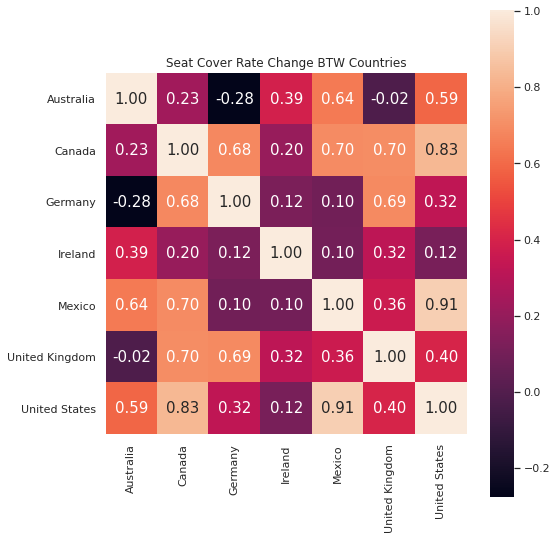

In [ ]:
# covariance matrix for countries data
cols = countries_df.columns;
countries_df_cleaned = countries_df.dropna(how='any', subset=cols)
countries_df_cleaned.drop(columns=['Global'], inplace=True)
covariance_matrix_analysis(countries_df_cleaned, (8,8), "Seat Cover Rate Change BTW Countries")

### Data Point Consecutive Check
**Motivation:** We hope will not lose any daily data in the opentable u.s. and global data from 2020-02-18 to 2021-04-08.

**Question:**
*   Whether the global data are consecutive (standard: consecutive days)
<br> Notate the earliest data point timestamp and latest data point timestamp
*   Whether the US data are consecutive (standard: consecutive days )
<br> Notate the earliest data point timestamp and latest data point timestamp  

**Conclusion:** Both global and the u.s. opentable table data are consecutive.  

#### Global Data Consecutive Check

In [ ]:
global_df = opentable_df[['Timestamp','TimeObj', 'Global']].copy()
global_df.dropna(how = 'any',inplace= True)
print('Global data are consecutive: ', check_data_is_consecutive(global_df.copy()))
print('Earliest data point of the global data is: ', global_df.iloc[0,]['TimeObj'])
l = len(global_df)
print('Latest data point of the global data is: ', global_df.iloc[l-1,]['TimeObj'])

Global data are consecutive:  True
Earliest data point of the global data is:  2020-02-18 00:00:00
Latest data point of the global data is:  2021-04-08 00:00:00


#### US Data Consecutive Check

In [ ]:
us_df = opentable_df[['Timestamp','TimeObj', 'United States']].copy()
us_df.dropna(how = 'any',inplace= True)
print('Global data are consecutive: ', check_data_is_consecutive(global_df.copy()))
print('Earliest data point of the us data is: ', us_df.iloc[0,]['TimeObj'])
l = len(global_df)
print('Latest data point of the us data is: ', us_df.iloc[l-1,]['TimeObj'])

Global data are consecutive:  True
Earliest data point of the us data is:  2020-02-18 00:00:00
Latest data point of the us data is:  2021-04-08 00:00:00


### Visualization: Daily Seated Dinner Rate Change
**Movitation:** We are curious about the daily seated dinner change rate globally and in the U.S.

**Conclusion:**
1. We can see the pattern of global daily seated dinner rate change is similar to the pattern of the U.S. daily seated dinner rate change.
2. After the start of the pandemicc, during first several days (Feb.22 2020 to Mar. 1st 2020), the daily seated dinner rate dropped to its lowest point.
3. Afterwards, people returned to restaurants and the daily seated dinner rate began to rise back to normal levels.      

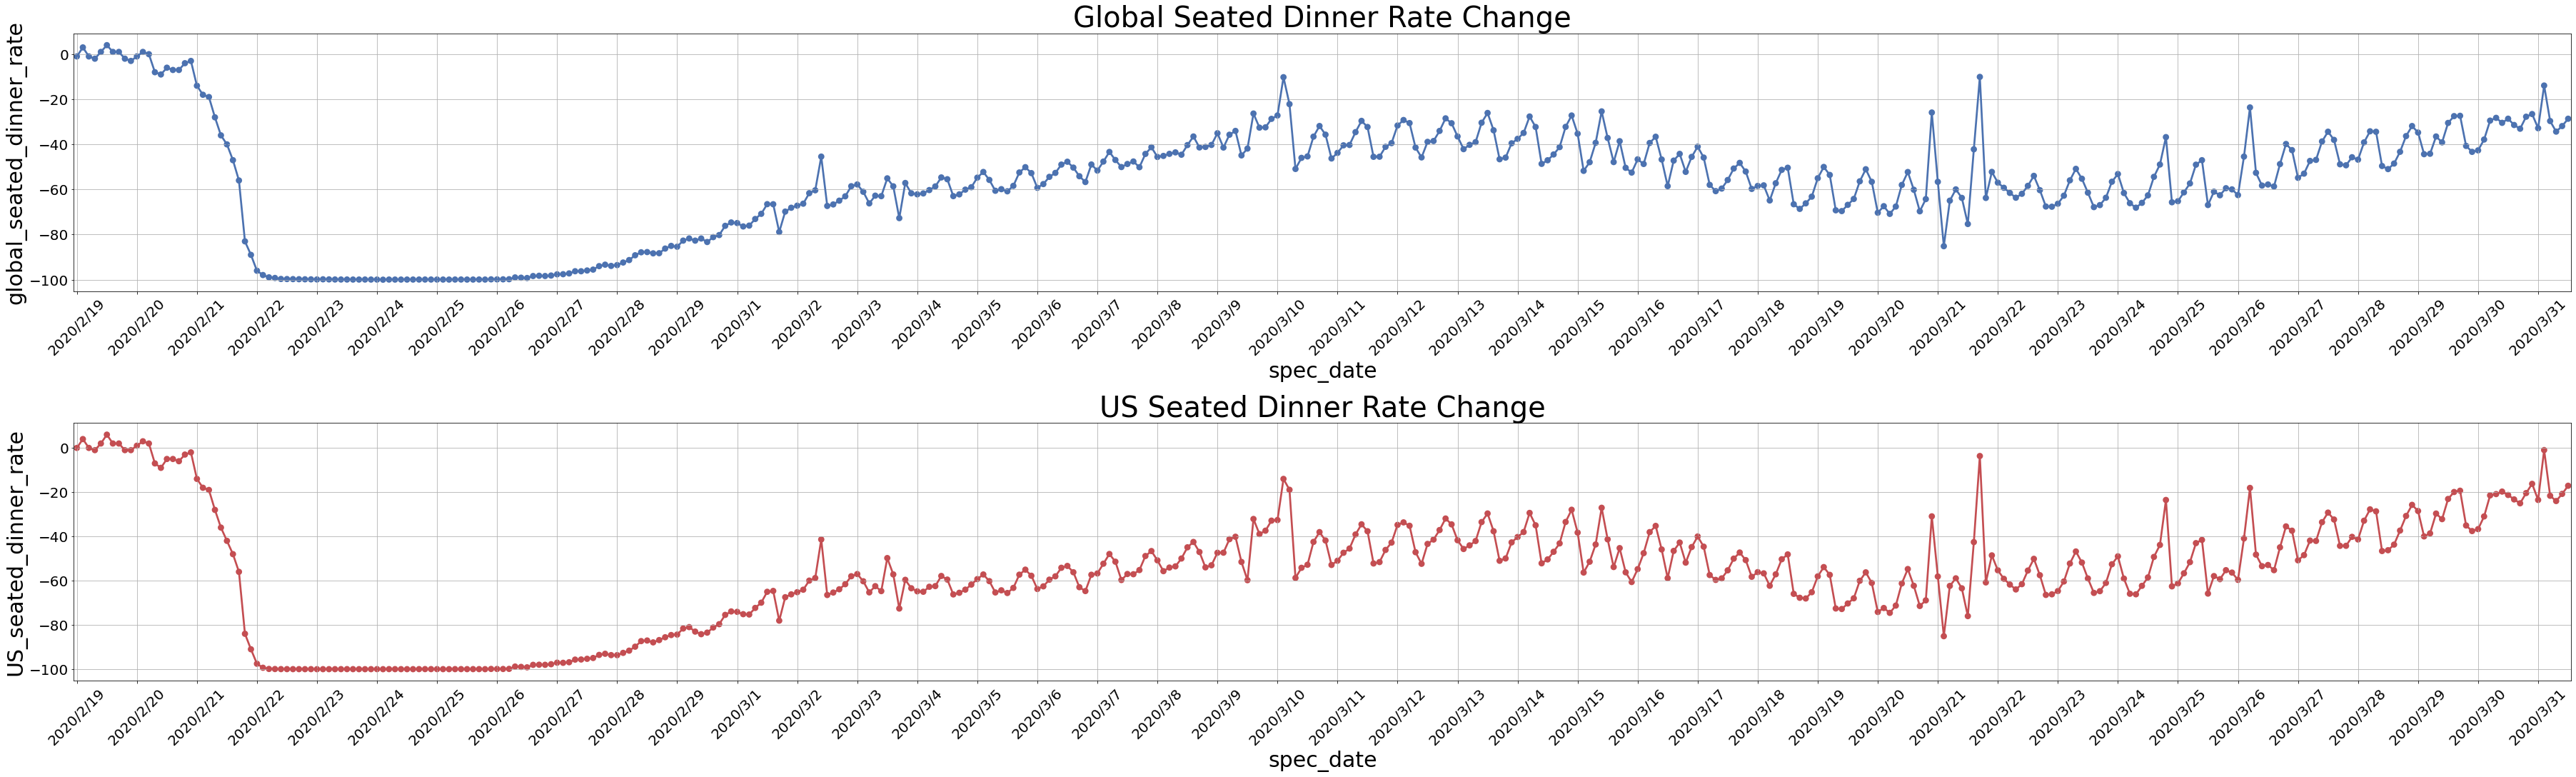

In [ ]:
import matplotlib.ticker as ticker
########################### Data extraction ##############################
global_df_partial = global_df[['Timestamp', 'Global']].copy()
us_df_partial = us_df[['Timestamp', 'United States']].copy()
############################# GRAPH ######################################
f, axs = plt.subplots(2,1, figsize=(50, 15), constrained_layout=True)
### first figure
sns.set_theme(style="dark")
ax1 = sns.pointplot(ax = axs[0], data= global_df_partial,  x= 'Timestamp', y='Global', ci="sd");
ax1.axes.set_title("Global Seated Dinner Rate Change",fontsize=40)
# set some ticks parameters
ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.tick_params(axis = 'x', labelsize = 20)
ax1.tick_params(axis = 'y', labelsize = 20)
ax1.set_xlabel("spec_date", fontsize = 30)
ax1.set_ylabel("global_seated_dinner_rate",fontsize = 30)
ax1.tick_params(axis='x', rotation=45)
ax1.grid();

### second figure
ax2 = sns.pointplot(ax = axs[1], data = us_df_partial, x= 'Timestamp', y= 'United States',color= 'r')
ax2.axes.set_title("US Seated Dinner Rate Change",fontsize=40)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.tick_params(axis = 'x', labelsize = 20)
ax2.tick_params(axis = 'y', labelsize = 20)
ax2.set_xlabel("spec_date",fontsize = 30)
ax2.set_ylabel("US_seated_dinner_rate",fontsize = 30)
ax2.tick_params(axis='x', rotation=45)
ax2.grid();

#### Visualization: Average Seated Dinner Rate Change
**Motivation:** Since the daily seated dinner rate may not be representative, it might be better to get the seven day average.  
**Procedures:**
1. We compute the average value every 7 days.
2. We do the analysis per country.
**Conclusion:**
1. There are some general conclusions for seated dinner rate change. In the early days of the pandemic, the average seated dinner rate dropped to its lowest point, which makes sense because people were wary of the virus.  
2. Activity rises to normal levels gradually. This also makes sense since people learned to live with the virus
3. Around Christmas, average seated dinner rate rose to its highest values. During holidays, people gathered more frequently.   



##### Helper function
* Moving Average Computation

In [ ]:
### Moving average computation
def compute_avg_in_n_days(timestamp, df, attr, n):
  # find the row idx
  idx = df[df['Timestamp'] == timestamp].index[0]
  # compute the avg of several days
  if n%2==1:
    mid_idx = (int)(n/2)
    if idx < mid_idx or idx >= df.shape[0]-mid_idx:
      return df.iloc[idx][attr]
  if n%2==0:
    mid_idx = n/2
    if idx< mid_idx-1 or idx>= df.shape[0]-mid_idx:
      return df.iloc[idx][attr]
  # compute the start and ending idx
  start_idx = 0;
  end_idx = 0;
  if n % 2==1:
    # when n is odd
    start_idx = idx - (int)(n/2)
    end_idx = idx + (int)(n/2)
  else:
    # when n is even
    start_idx = idx-(int)(n/2)+1
    end_idx = idx+ (int)(n/2)
  # start_idx and end_idx error check
  assert(end_idx- start_idx+1 == n)
  # compute the sum
  sum = 0
  for i in range(start_idx, end_idx+1, 1):
    sum += df.iloc[i][attr]
  avg = sum/n;
  return avg

def compute_moving_avg(df, attr, n):
  new_attr= attr+'_'+str(n)+'_avg'
  res_df = df.copy();
  res_df[new_attr] = res_df[attr]
  res_df[new_attr] = res_df['Timestamp'].apply(compute_avg_in_n_days,
                                               args=(df, attr , n))
  return res_df;

##### Compute the average change for each country over 7 days

In [ ]:
df_avg = countries_df.copy()
cols = df_avg.columns
for attr in cols:
  if attr == 'Timestamp' or attr=='TimeObj':
    continue
  else:
    df_avg = compute_moving_avg(df_avg, attr , 7)
display(df_avg.head(5))

Timestamp    TimeObj  ...  United Kingdom_7_avg  United States_7_avg
0  2020/2/18 2020-02-18  ...              1.000000             0.000000
1  2020/2/19 2020-02-19  ...             -1.000000             4.000000
2  2020/2/20 2020-02-20  ...             -2.000000             0.000000
3  2020/2/21 2020-02-21  ...             -1.857143             1.857143
4  2020/2/22 2020-02-22  ...             -2.714286             2.142857

[5 rows x 18 columns]

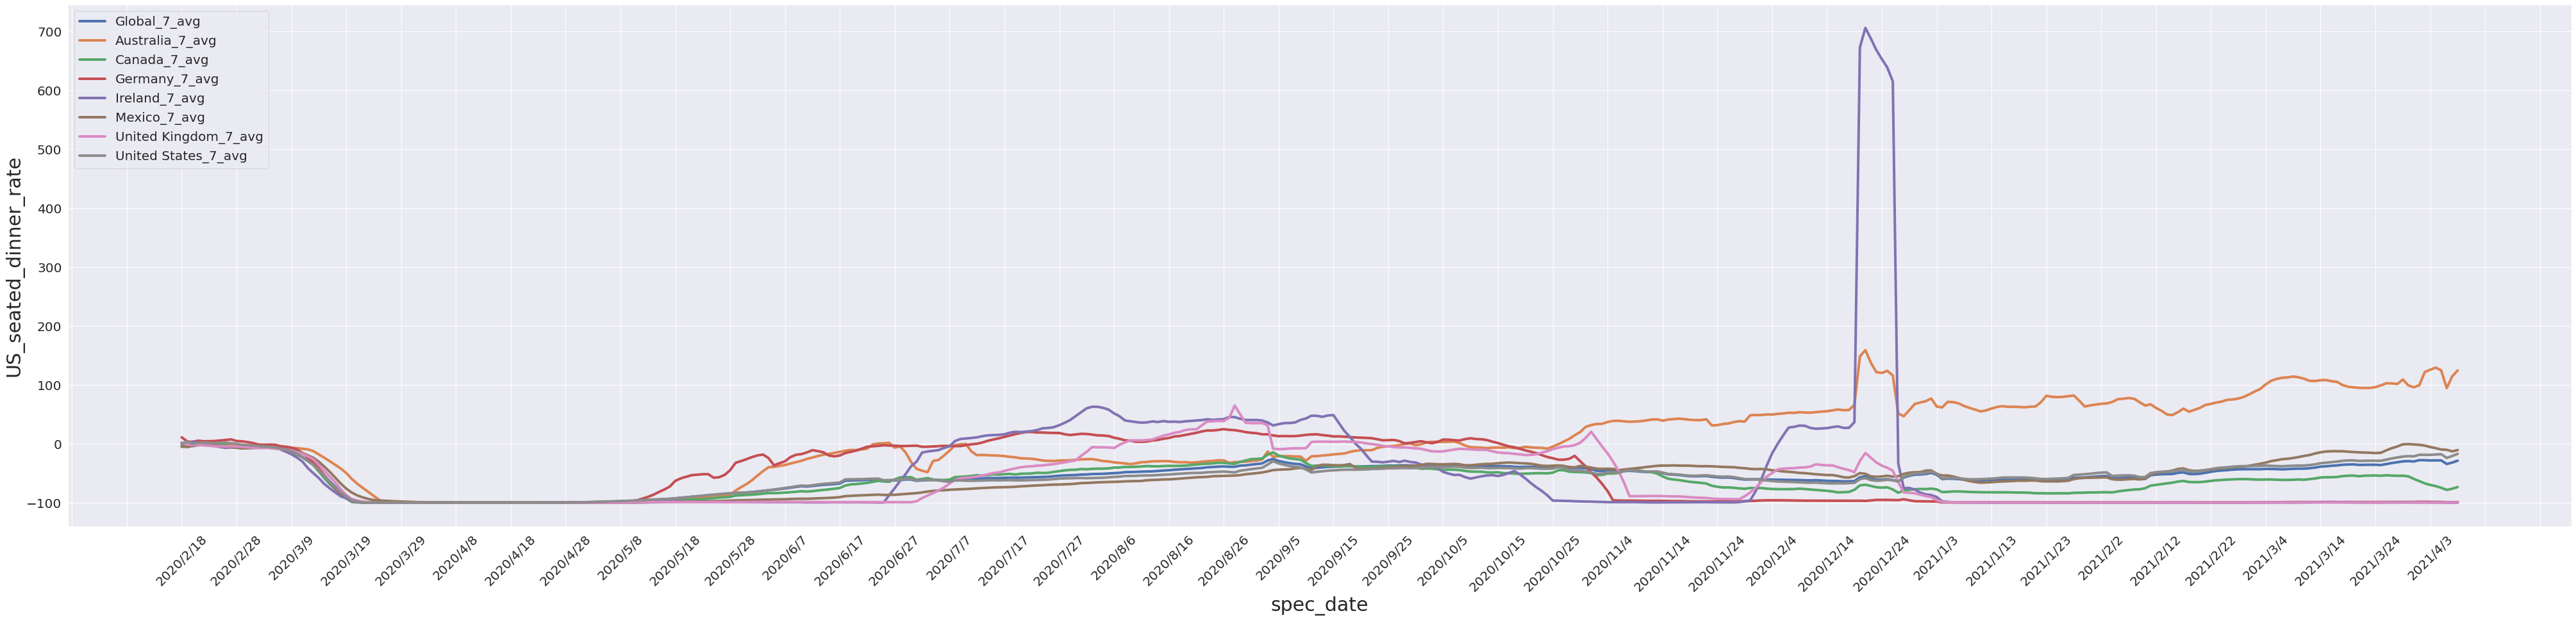

In [ ]:
import matplotlib.ticker as ticker
import matplotlib
############################# GRAPH ######################################
plt.figure(figsize=(70, 15));
cols = [];
for attr in df_avg.columns:
  if attr== 'Timestamp' or attr=='TimeObj' or attr.endswith('_avg')== False:
    continue;
  cols.append(attr)
l = len(cols)
axs = np.zeros(l, matplotlib.axes.Axes)
count = 0;
for attr in cols:
  axs[count] = sns.lineplot(data= df_avg, x= 'Timestamp', y= attr, label = attr,
                            linewidth = 4)
  axs[count].xaxis.set_major_locator(ticker.MultipleLocator(10))
  axs[count].tick_params(axis = 'x', labelsize = 20)
  axs[count].tick_params(axis = 'y', labelsize = 20)
  axs[count].set_xlabel("spec_date",fontsize = 30)
  axs[count].set_ylabel("US_seated_dinner_rate",fontsize = 30)
  axs[count].tick_params(axis='x', rotation=45)
  axs[count].grid();
  count= count+1;
plt.grid();
plt.legend(loc=2, prop={'size': 20})

## Tweets Dataset EDA

### Relevant package installation

In [ ]:
pip install geopandas

     |████████████████████████████████| 1.0MB 5.4MB/s 
     |████████████████████████████████| 6.5MB 10.0MB/s 
     |████████████████████████████████| 15.3MB 223kB/s 


In [ ]:
pip install geopy

In [ ]:
pip install folium

In [ ]:
pip install googletrans==3.1.0a0

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 1.0MB 8.5MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-cp37-none-any.whl size=16368 sha256=6e06f0742439d08a11c5e1a50bb283ca51b572afc38b3913c09acee9d401e661
  Stored in directory: /root/.cache/pip/wheels/27/7a/a0/aff3babbb775549ce6813cb8fa7ff3c0848c4dc62c20f8fdac
Successfully built googletrans


In [ ]:
pip install pycountry

     |████████████████████████████████| 10.1MB 5.5MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=f8c29272f0ecb83a370059f18d90d78b5355ec6ad5de3024e322b010b1129483
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


### Helper function


In [ ]:
from googletrans import Translator, constants
import geopandas
from geopy.geocoders import Nominatim
import pycountry
### Helper function 1:
### format the columns name
def format_columns_names(df):
  cols = df.columns
  new_cols = [];
  for col in cols:
    new_col= col.lower();
    new_cols.append(new_col)
  df.columns = new_cols;
  return df;

# attatch country geocode
geolocator = Nominatim()
def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

def retrieve_country_name_from_country_code(code):
    alpha_2_code = code.upper();
    country = pycountry.countries.get(alpha_2=alpha_2_code)
    return country.name;

def translate_country_field(df):
  df['translated_country'] = df['country_code'].apply(lambda x: retrieve_country_name_from_country_code(x))
  return df;

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


### Data Loading, Cleaning & Information Retrieval
Here, we do the following things:
1.   Load tweets data from the CSV file.
2.   Translate the country name by conducting an API call on the country code.
<br> We have to do this because the country in the original tweets dataset is in the country's respective language, which makes interpretation and processing more difficult.

In [ ]:
### tweets data downloading
tweets_df_ori = pd.read_csv('tweets.csv')
### format the columns name
tweets_df = format_columns_names(tweets_df_ori)
tweets_df = translate_country_field(tweets_df)
display(tweets_df.head(5))

tweet_id  ... translated_country
0  1371409637690511360  ...        Philippines
1  1365296066552238081  ...             Canada
2  1349313197350666241  ...     United Kingdom
3  1370366472632086528  ...     United Kingdom
4  1347280195502415875  ...      United States

[5 rows x 10 columns]

### Tweets DataFrame Data Conclusion
*  Column Information Check
*  Data size conclusion

In [ ]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18169 entries, 0 to 18168
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            18169 non-null  int64  
 1   text                18169 non-null  object 
 2   date                18169 non-null  object 
 3   latitude            18169 non-null  float64
 4   longitude           18169 non-null  float64
 5   city                18169 non-null  object 
 6   country             18169 non-null  object 
 7   state               18169 non-null  object 
 8   country_code        18169 non-null  object 
 9   translated_country  18169 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1.4+ MB


### Convariance Matrix Analysis -- Correlation exploration
Exploring tweet correlation using latitude and longitude



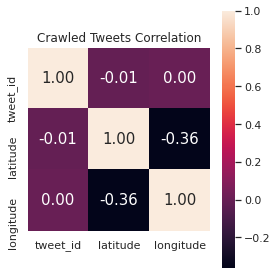

In [ ]:
cols = tweets_df.columns;
tweets_df_cleaned = tweets_df.dropna(how='any', subset=cols)
covariance_matrix_analysis(tweets_df_cleaned, (4,4), "Crawled Tweets Correlation")

### Tweets Geo-Distribution Check

#### Data Point Distribution Display
**Motivation:** In the tweets dataset, there is geographic information. We are curious about the distribution of tweets around the world




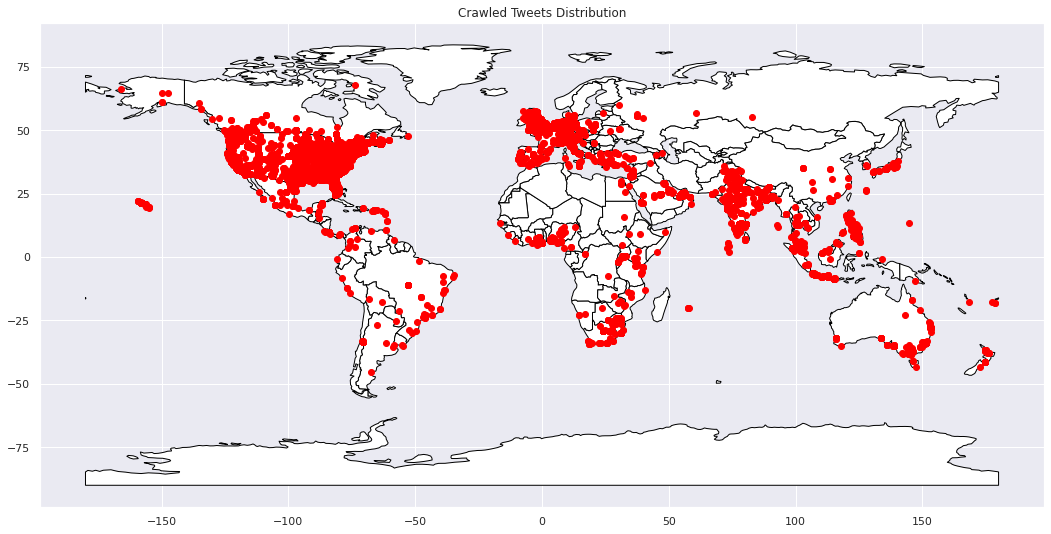

In [ ]:
gdf = geopandas.GeoDataFrame(tweets_df, geometry=geopandas.points_from_xy(tweets_df['longitude'], tweets_df['latitude']))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# We restrict to South America.
ax = world.plot(figsize=(18,20), legend = True, color='white', edgecolor='black',
                legend_kwds={'label': "Crawled Tweets Distribution",
                          'orientation': "horizontal"})
#removing axis ticks
gdf.plot(ax=ax, color='red')
plt.title("Crawled Tweets Distribution")
plt.show()

In [ ]:
tweets_count_df = tweets_df[['translated_country', 'tweet_id']].groupby('translated_country').count().reset_index();
tweets_count_df.rename(columns = {'tweet_id':'count'}, inplace= True);
# append to country code
tweets_count_df['geolocate'] = tweets_count_df['translated_country'].apply(lambda x: geolocate(x))
tweets_count_sorted_df = tweets_count_df.sort_values(by=['count'], ascending= False)

#### Data Point Distribution By Country
**Motivation:** Although it is helpful to mark each tweet data point on the map, it is hard to how many tweets come from each country. Since we will use the tweets data to predict the U.S new covid case, we want to make sure there are enough tweets from the U.S.

**Conclusion:** We rank the country by total tweets. We can see that most tweets come from the U.S. (about 9220). Next is the United Kingdom at 4106 tweets. Next is Canada with 1450.
<br> After this check, we can there should be enough tweets from the U.S.

Ref: [link_to_create_world_map_from_a_list_of_country_names](https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10)

In [ ]:
import folium
from folium.plugins import MarkerCluster
def display_data_on_map_by_country(df):
  # empty map
  world_map= folium.Map(tiles="cartodbpositron")
  marker_cluster = MarkerCluster().add_to(world_map)
  # for each coordinate, create circlemarker of user percent
  for i in range(len(df)):
    geolocate = df.iloc[i]['geolocate']
    radius=10
    popup_text = """No.{} Country:{} <br> Tweets Count:{}"""
    popup_text = popup_text.format(i+1, df.iloc[i]['translated_country'],df.iloc[i]['count'])
    folium.CircleMarker(location = geolocate, radius=radius, popup = popup_text, fill =True).add_to(marker_cluster)
  # display the map
  display(world_map)
  return world_map
display_data_on_map_by_country(tweets_count_sorted_df.head(40))

#### US Tweets Distribution Over Month
**Motivation:** Although there are enough tweets in the U.S, we still need to check the monthly distribution of tweets. We hope that there are roughly the same number of tweets in the U.S each month.

**Conclusion:** We can see that from 2020-10 to 2021-03, there are enough tweets per month.

In [ ]:
tweets_us_df = tweets_df_cleaned[tweets_df_cleaned.country_code== 'us']
# only display the US data
display(tweets_us_df.head(5));
# adding the month
tweets_us_df['month'] = tweets_us_df['date'].apply(lambda x: x[0:7])
tweets_us_monthly_count = tweets_us_df[['tweet_id', 'month']].groupby('month').count().reset_index().rename(columns= {'tweet_id': 'tweet_count'});
display(tweets_us_monthly_count)

tweet_id  ... translated_country
4   1347280195502415875  ...      United States
7   1368323414835015682  ...      United States
18  1345762419969302529  ...      United States
21  1314944637602164736  ...      United States
22  1325851188156313601  ...      United States

[5 rows x 10 columns]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


month  tweet_count
0  2020-03          123
1  2020-10         1553
2  2020-11         1618
3  2020-12         1691
4  2021-01         1347
5  2021-02         1192
6  2021-03         1681
7  2021-04           15

## Sentiment EDA

We collapse all of the tweets' sentiment scores in a given day into the average sentiment per day, and then we fit a SARIMA model to detrend and desesonalize the data.

In [ ]:
tweets_df = pd.read_csv("/content/drive/My Drive/545finalproject/feature_engineering/tweets_w_features.csv")

In [ ]:
query = """
SELECT date, AVG(score)
FROM (SELECT * FROM tweets_df WHERE date > '2020-08-01')
GROUP BY date
"""

tweets_by_date = ps.sqldf(query, locals())

tweets_by_date

date  AVG(score)
0    2020-10-01    1.000000
1    2020-10-02    0.473684
2    2020-10-03    0.807692
3    2020-10-04    0.538462
4    2020-10-05   -0.314286
..          ...         ...
178  2021-03-28    2.155556
179  2021-03-29    1.631579
180  2021-03-30    1.206349
181  2021-03-31    2.121212
182  2021-04-01    1.266667

[183 rows x 2 columns]

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = tweets_by_date['date'],
    y = tweets_by_date['AVG(score)']
))

fig.update_layout(
    title = "Average sentiment score through time",
    xaxis_title = "Time",
    yaxis_title = "AFINN score",
)

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = tweets_by_date['date'],
    y = tweets_by_date['AVG(score)'].diff()
))

fig.update_layout(
    title = "Daily change in average sentiment score through time",
    xaxis_title = "Time",
    yaxis_title = "AFINN score",
)

fig.show()

There is evidence of a trend component and seasonal variation. We filter out the trend and noise to obtain true signals.

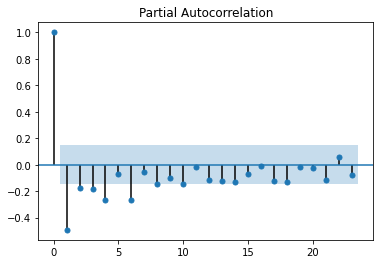

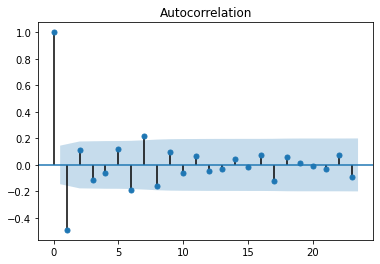

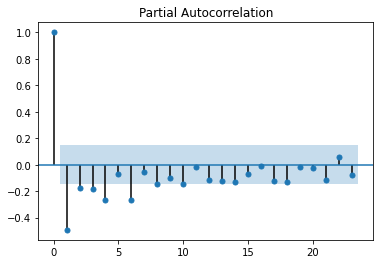

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
tweets_diff = tweets_by_date['AVG(score)'].diff()[1:] # ARIMA(0,1,0)
plot_acf(pd.Series(tweets_diff))
plot_pacf(pd.Series(tweets_diff))

There are statistically significant lags at 1 and 7, suggesting an AR(1) or MA(1) model with 7-period seasonal SAR(1) or SMA(1) model fits.

An ARIMA(2,0,1)(0,0,1,7) model is selected as it yields residuals that resemble white noise:

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(tweets_by_date['AVG(score)'], order = [2, 1, 1],
              seasonal_order = [0, 0, 1, 7]).fit()
results_ARIMA = model.predict()
tweets_by_date_arima = pd.concat([tweets_by_date[['date']],
                                 results_ARIMA], axis = 1)
tweets_by_date_arima.columns = ['date', 'score']

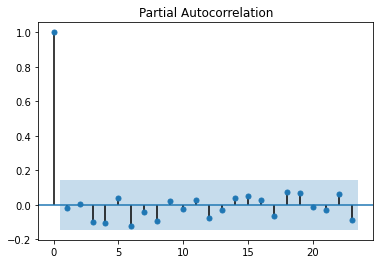

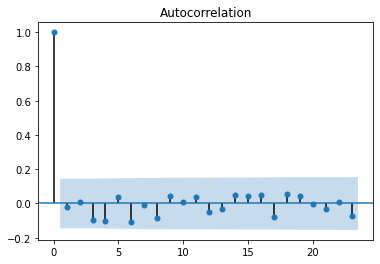

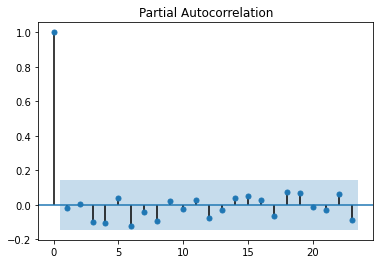

In [ ]:
plot_acf(pd.Series(model.resid))
plot_pacf(pd.Series(model.resid))

There is adequate reduction to noise.

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x = tweets_by_date['date'],
               y = tweets_by_date['AVG(score)'], name = "Original"),
)

fig.add_trace(
    go.Scatter(x = tweets_by_date_arima['date'],
               y = tweets_by_date_arima['score'], name = "ARIMA(2,1,1)(0,0,1,7)"),
)

fig.update_layout(
    title = "Average sentiment score through time",
    xaxis_title = "Time",
    yaxis_title = "AFINN score",
)

fig.show()

## Combined Dataset EDA


### Data Load, Cleaning & Information Retrieving

In [ ]:
# read the final data frame
complete_df = pd.read_csv('features_and_labels.csv');
# drop the rows that contains the null value
complete_df = complete_df.dropna(how= 'any');
# drop the first unnamed columns
complete_df = complete_df.drop(columns = 'Unnamed: 0');
# display the first 5 rows
complete_df.head(5)

state  score  ...  lag14_wkly_change_roll:Wednesday  new_cases
0      Florida    0.0  ...                               0.0   295215.0
1      Florida    0.0  ...                               0.0    41007.0
2   Washington    0.0  ...                               0.0   184282.0
3  Mississippi    2.0  ...                               0.0    45941.0
4     New York    0.0  ...                               0.0   140496.0

[5 rows x 51 columns]

### Combined Dataframe Data Conclusion

In [ ]:
complete_df.info(verbose = True);

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9220 entries, 0 to 9219
Data columns (total 51 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   state                             9220 non-null   object 
 1   score                             9220 non-null   float64
 2   lag14                             9220 non-null   float64
 3   lag14_dd_change                   9220 non-null   float64
 4   lag14_wkly_change                 9220 non-null   float64
 5   lag14_roll                        9220 non-null   float64
 6   lag14_dd_change_roll              9220 non-null   float64
 7   lag14_wkly_change_roll            9220 non-null   float64
 8   Friday                            9220 non-null   int64  
 9   Monday                            9220 non-null   int64  
 10  Saturday                          9220 non-null   int64  
 11  Thursday                          9220 non-null   int64  
 12  Tuesda

### Convariance Matrix Analysis -- Correlation exploration

*   Draw the covariance matrix



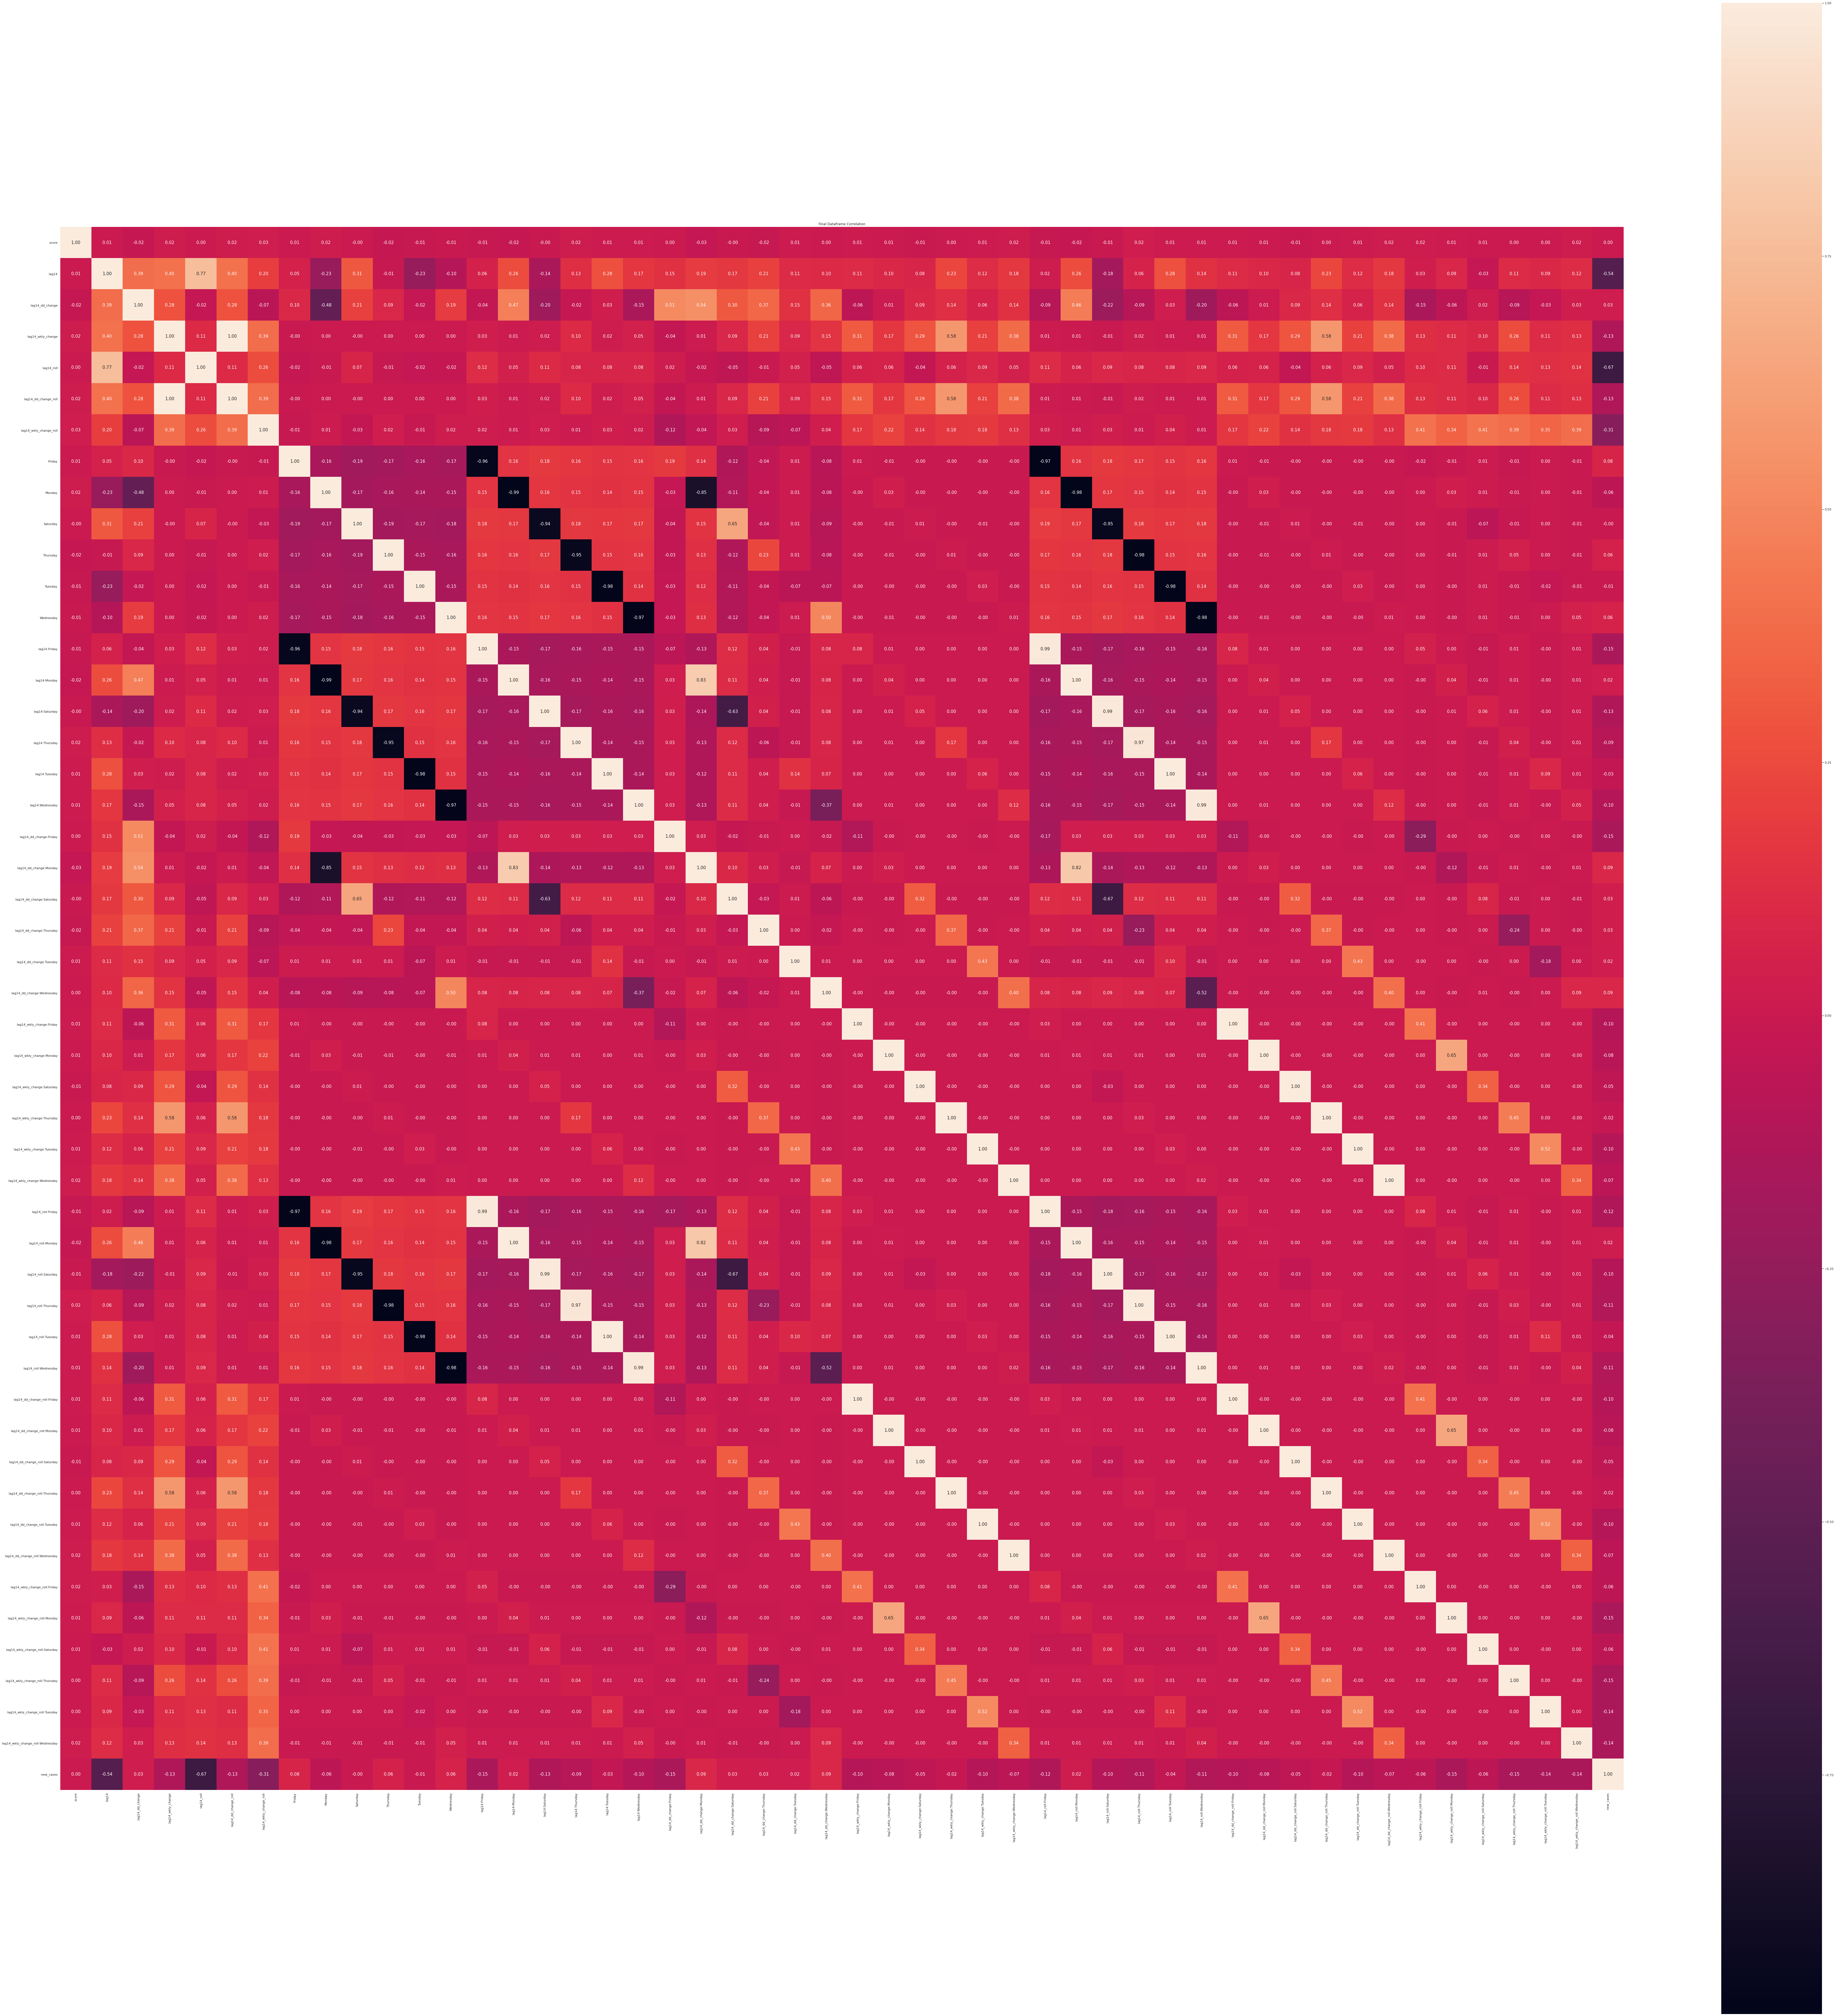

In [ ]:
cols = list(complete_df.columns);
covariance_matrix_analysis(complete_df, (100,100), "Final Dataframe Correlation")

# Model Training & Prediction

## Package Import & Helper Function

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

Helper function to display the predicted and true value

In [ ]:
def train_bayesian_model_with_diff_params(model_type, alpha_values, X_scaled, y, test_size, model_list= None, train_accuracy_list= None, test_accuracy_list=None):
  # initialize the result
  if train_accuracy_list == None:
    train_accuracy_list = [];
  if test_accuracy_list == None:
    test_accuracy_list = [];
  if model_list == None:
    model_list = [];

  for spec_alpha in alpha_values:
    # split the training and testing dataset
    (X_train, X_test, y_train, y_test) = train_test_split(X_scaled, y, test_size= test_size, random_state=42)
    if model_type == 'Ridge':
      model = Ridge(alpha=spec_alpha, max_iter= 10e5);
    if model_type == 'Lasso':
      model = Lasso(alpha= spec_alpha, max_iter= 10e5);

    model.fit(X_train, y_train);
    model_list.append(model);
    train_accuracy = model.score(X_train, y_train);
    test_accuracy = model.score(X_test, y_test);
    train_accuracy_list.append(train_accuracy);
    test_accuracy_list.append(test_accuracy);
    # format the result for better result display
    spec_alpha = format(spec_alpha, '.6f')
    train_accuracy = format(train_accuracy, '.13f')
    test_accuracy = format(test_accuracy, '.13f')
    print("{} Model with alpha {} Performance || Train_accuracy:{}, Test_accuracy:{}".format(model_type, spec_alpha, train_accuracy, test_accuracy));
  return model_list, train_accuracy_list, test_accuracy_list;

def train_random_forest_model_with_diff_params(depth_list, X_decomposed, y, test_size,
                                               model_list, train_accuracy_list, test_accuracy_list):
  for depth in depth_list:
    # split the training data and test data for each round
    (X_train, X_test, y_train, y_test) = train_test_split(X_decomposed, y, test_size= test_size, random_state=42)
    # initialize the random forest classifiers
    clf = RandomForestClassifier(max_depth= depth);
    clf.fit(X_train, y_train);
    model_list.append(clf);
    train_score = clf.score(X_train, y_train);
    train_accuracy_list.append(train_score);
    test_score = clf.score(X_test, y_test);
    test_accuracy_list.append(test_score);
    depth = format(depth, '.1f');
    train_score = format(train_score, '.13f');
    test_score = format(test_score, '.13f');
    print("Random forest tree max_depth: {} || train_accuracy: {} || test_accuracy: {}".format(depth, train_score, test_score));

def display_training_curve(graph_type, model_name, tune_param_name, params, train_accuracies, test_accuracies):
  if graph_type == 'curve':
    plt.plot(params, train_accuracies, '-', label = 'train_accuracy')
    plt.plot(params, test_accuracies, '--', label = 'test_accuracy')
  if graph_type == 'scatter_plot':
    plt.scatter(params, train_accuracies, label = 'train_accuracy')
    plt.scatter(params, test_accuracies, label = 'test_accuracy')
  plt.title('{} Model Accuracy with different {} params'.format(model_name, tune_param_name))
  plt.xlabel(tune_param_name)
  plt.ylabel('Accuracy')
  plt.legend(loc= 0, prop={'size': 10})
  plt.show()

def select_best_model(model_type, tune_param_name, params, model_list, train_accuracies, test_accuracies):
  idx = np.argmax(test_accuracies);
  best_model = model_list[idx]
  best_param_value = params[idx]
  best_model_train_score = train_accuracies[idx]
  best_model_test_score = test_accuracies[idx]
  print("----- {} Model Selection Conclusion -----".format(model_type));
  print("----- We select the best model by highest training accuracy. ----");
  print("Best {} Model has param [{}] with value [{}].".format(model_type, tune_param_name, best_param_value))
  print("Best {} Model Training Accuracy: [{}].".format(model_type, best_model_train_score))
  print("Best {} Model Testing accuracy: [{}].".format(model_type, best_model_test_score))
  return best_model;

def compare_predicted_and_true_value(num = 200, x_label = 'x', y_test= [], predicted_y_test= []):
  l = range(num)
  fig, (ax1, ax2) = plt.subplots(2, sharex=False, figsize=(9, 6))
  ax1.plot(l, y_test[0:num],'r')
  ax1.set_xlabel(x_label)
  ax1.set_ylabel('true y value')
  ax1.set_title('True y value in test dataset (for first {} data points)'.format(num))
  ax2.plot(l, predicted_y_test[0:num], 'b')
  ax2.set_xlabel(x_label)
  ax2.set_ylabel('predicted y value')
  ax2.set_title('Predicted y value in test dataset (for first {} data points)'.format(num))
  fig.tight_layout(pad=2.0)

## Bayesian Linear Models


### 1. Data import and preprocessing (Unaggregated)
For the following models, we will do the following preprocessing:
*   Drop the state column.
*   Scale X by Min-Max scalar.
*   Columns except for new_cases columns are feature columns, will be treated as X. The dimensionality of features is 51.
*   *new_cases* columns is the label that we want to predict, will be treated as y.

In [ ]:
#import data
final_df = pd.read_csv("features_and_labels.csv")
#separate labels and features
#drop the state column
train_df = final_df.drop(columns = ['state'])
y_batch = train_df.iloc[:,-1].to_numpy()
y_batch = y_batch[:, None]
train_df = train_df.iloc[:, :-1]
x_batch = train_df.to_numpy()

#min max scale the features
sc = MinMaxScaler()
x_batch=sc.fit_transform(x_batch)

print("Features shape {}".format(x_batch.shape))
print("Label shape {}".format(y_batch.shape))

Features shape (9220, 50)
Label shape (9220, 1)


### 2. Split the training data and testing data
*   80% of the data will be used for training, 20% of the data will be used for testing.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_batch, y_batch, test_size=0.2, random_state=42)
# check the training tensor and testing tensor size
print("Training Data Size: features x:{},  label y:{}".format(X_train.shape, y_train.shape))
print("Testing Data Size: features x:{},  label y:{}".format(X_test.shape, y_test.shape))

Training Data Size: features x:(7376, 50),  label y:(7376, 1)
Testing Data Size: features x:(1844, 50),  label y:(1844, 1)


### Ridge Model Training and Performance Analysis
**Ridge regression loss function:** $||y-Xw||_2^2 + \alpha ||w||_2^2$

**Conclusion:**
1. By training the ridge regression model with different alpha values and comparing the training accuracy of different alpha values, we find the best ridge regression model.
2. The best ridge regression model will have $\alpha = 0.001$.
3. By using this model, accuracy on the training dataset will be 0.6342.
4. By using this model, accuracy on the testing dataset will be around 0.6424.
 <br> rooted mean square error: $RMSE=41607.1170$.  
 mean absolute error: $MAE=32914.5608$.


#### Model Training with different $\alpha$ values

In [ ]:
alpha_values_list = [5,4,3,2,1,0.5, 0.1, 0.05, 0.01, 0.005, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5,
                     5e-6, 1e-6, 5e-7, 1e-7];
ridge_model_list, ridge_train_accur_list, ridge_test_accur_list = train_bayesian_model_with_diff_params(model_type='Ridge',
                                                                                                        alpha_values= alpha_values_list,
                                                                                                        X_scaled= x_batch,
                                                                                                        y= y_batch,
                                                                                                        test_size = 0.2)

Ridge Model with alpha 5.000000 Performance || Train_accuracy:0.5856655598770, Test_accuracy:0.5855313208437
Ridge Model with alpha 4.000000 Performance || Train_accuracy:0.5903939138125, Test_accuracy:0.5909491777478
Ridge Model with alpha 3.000000 Performance || Train_accuracy:0.5964555093348, Test_accuracy:0.5979697483547
Ridge Model with alpha 2.000000 Performance || Train_accuracy:0.6045630722393, Test_accuracy:0.6074873011671
Ridge Model with alpha 1.000000 Performance || Train_accuracy:0.6159568309748, Test_accuracy:0.6211150041486
Ridge Model with alpha 0.500000 Performance || Train_accuracy:0.6236557964397, Test_accuracy:0.6304331362365
Ridge Model with alpha 0.100000 Performance || Train_accuracy:0.6321710051048, Test_accuracy:0.6403360206853
Ridge Model with alpha 0.050000 Performance || Train_accuracy:0.6334473753692, Test_accuracy:0.6416970101276
Ridge Model with alpha 0.010000 Performance || Train_accuracy:0.6341768240045, Test_accuracy:0.6424169016632
Ridge Model with al

Visualize the training result to avoid overfitting.

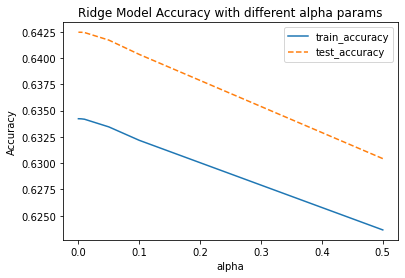

In [ ]:
display_training_curve(graph_type = 'curve',
                       model_name='Ridge',
                       tune_param_name='alpha',
                       params= alpha_values_list[5:],
                       train_accuracies = ridge_train_accur_list[5:],
                       test_accuracies = ridge_test_accur_list[5:])

#### Model Selection and Performance Analysis

In [ ]:
best_ridge_model = select_best_model(model_type = 'Ridge Regression',
                  tune_param_name = 'alpha',
                  params = alpha_values_list,
                  model_list = ridge_model_list,
                  train_accuracies = ridge_train_accur_list,
                  test_accuracies = ridge_test_accur_list)

----- Ridge Regression Model Selection Conclusion -----
----- We select the best model by highest training accuracy. ----
Best Ridge Regression Model has param [alpha] with value [0.001].
Best Ridge Regression Model Training Accuracy: [0.6342244134967117].
Best Ridge Regression Model Testing accuracy: [0.6424450247725901].


In [ ]:
ridge_y_pred = best_ridge_model.predict(X_test)
ridge_RMSE = mean_squared_error(y_test, ridge_y_pred) ** 0.5
print("Best Ridge Regression Model RMSE: {}".format(ridge_RMSE))
ridge_errors = y_test - ridge_y_pred
#mean absolute error
ridge_MAE = np.average(np.abs(ridge_errors))
print("Best Ridge Regression Model MAE: {}".format(ridge_MAE))

Best Ridge Regression Model RMSE: 41607.117091906046
Best Ridge Regression Model MAE: 32914.56078309031


### Lasso Model Training and Perfomance Analysis
**Lasso loss function:**
 $\frac{1}{2n_{samples}}\cdot ||y-x_w||_{2}^{2} + \alpha ||w||_1$

 **Conclusion:**
1. By training the lasso regression model with different alpha values and comparing the training accuracy of different alpha values, we find the best lasso regression model.
2. The best lasso regression model will have $\alpha = 0.0005$.
3. By using this model, accuracy on the training dataset will be around 0.6342.  
4. By using this model, accuracy on the testing dataset will be around 0.6424.
 <br> rooted mean square error: $RMSE=41607.2447$.  
 mean absolute error: $MAE=72695.8781$.

#### Train Lasso Regression Model with different $\alpha$ values

In [ ]:
alpha_values_list = [5,4,3,2,1,0.5, 0.1, 0.05, 0.01, 0.005, 1e-3, 5e-4];
lasso_model_list, lasso_train_accur_list, lasso_test_accur_list = train_bayesian_model_with_diff_params(model_type='Lasso',
                                                                                                        alpha_values= alpha_values_list,
                                                                                                        X_scaled= x_batch,
                                                                                                        y= y_batch,
                                                                                                        test_size = 0.2)

Lasso Model with alpha 5.000000 Performance || Train_accuracy:0.6321248569486, Test_accuracy:0.6401713959326
Lasso Model with alpha 4.000000 Performance || Train_accuracy:0.6326908448349, Test_accuracy:0.6408117111895
Lasso Model with alpha 3.000000 Performance || Train_accuracy:0.6332756196325, Test_accuracy:0.6414441866034
Lasso Model with alpha 2.000000 Performance || Train_accuracy:0.6338024897904, Test_accuracy:0.6419925220409
Lasso Model with alpha 1.000000 Performance || Train_accuracy:0.6341191451912, Test_accuracy:0.6423256764607
Lasso Model with alpha 0.500000 Performance || Train_accuracy:0.6341984720396, Test_accuracy:0.6424113370620
Lasso Model with alpha 0.100000 Performance || Train_accuracy:0.6342238636320, Test_accuracy:0.6424417382527
Lasso Model with alpha 0.050000 Performance || Train_accuracy:0.6342246818419, Test_accuracy:0.6424425703308
Lasso Model with alpha 0.010000 Performance || Train_accuracy:0.6342249467622, Test_accuracy:0.6424425650511
Lasso Model with al

Visualize the Lasso regression result.

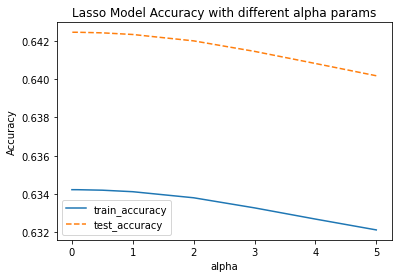

In [ ]:
display_training_curve(graph_type = 'curve',
                       model_name='Lasso',
                       tune_param_name='alpha',
                       params= alpha_values_list,
                       train_accuracies = lasso_train_accur_list,
                       test_accuracies = lasso_test_accur_list)

#### Model Selection and Performance Analysis

In [ ]:
best_lasso_model = select_best_model(model_type = 'Lasso Regression',
                  tune_param_name = 'alpha',
                  params = alpha_values_list,
                  model_list = lasso_model_list,
                  train_accuracies = lasso_train_accur_list,
                  test_accuracies = lasso_test_accur_list)

----- Lasso Regression Model Selection Conclusion -----
----- We select the best model by highest training accuracy. ----
Best Lasso Regression Model has param [alpha] with value [0.0005].
Best Lasso Regression Model Training Accuracy: [0.6342249546073939].
Best Lasso Regression Model Testing accuracy: [0.6424428307859524].


In [ ]:
lasso_y_pred = best_lasso_model.predict(X_test)
lasso_RMSE = mean_squared_error(y_test, lasso_y_pred) ** 0.5
print("Best Lasso Regression Model RMSE: {}".format(lasso_RMSE))
lasso_errors = y_test - lasso_y_pred
#mean absolute error
lasso_MAE = np.average(np.abs(lasso_errors))
print("Best Lasso Regression Model MAE: {}".format(lasso_MAE))

Best Lasso Regression Model RMSE: 41607.24474405078
Best Lasso Regression Model MAE: 72695.87806091036


## Random Forest Model

### 1. Preprocessing: Convert the state columns from string to numeric
Here, we do the following things:

*   Read the CSV files containing the combined data.
*   Drop instances that contain null field
*   Drop the unnamed column
*   Convert the state columns from string to numeric



In [ ]:
complete_df = pd.read_csv('features_and_labels.csv');
# drop the rows that contains the null value
complete_df = complete_df.dropna(how= 'any');
# drop the first unnamed columns
complete_df = complete_df.drop(columns = 'Unnamed: 0');
states_list = list(set(complete_df['state']))
states_list.sort()
d = dict();
count = 1;
for state in states_list:
  d[state] = count;
  count = count+1;
print('State Mapping From String to Number')
display(d)

State Mapping From String to Number


{'Alabama': 1,
 'Alaska': 2,
 'Arizona': 3,
 'Arkansas': 4,
 'California': 5,
 'Colorado': 6,
 'Connecticut': 7,
 'Delaware': 8,
 'District of Columbia': 9,
 'Florida': 10,
 'Georgia': 11,
 'Guam': 12,
 'Hawaii': 13,
 'Idaho': 14,
 'Illinois': 15,
 'Indiana': 16,
 'Iowa': 17,
 'Kansas': 18,
 'Kentucky': 19,
 'Louisiana': 20,
 'Maine': 21,
 'Maryland': 22,
 'Massachusetts': 23,
 'Michigan': 24,
 'Minnesota': 25,
 'Mississippi': 26,
 'Missouri': 27,
 'Montana': 28,
 'Nebraska': 29,
 'Nevada': 30,
 'New Hampshire': 31,
 'New Jersey': 32,
 'New Mexico': 33,
 'New York': 34,
 'North Carolina': 35,
 'North Dakota': 36,
 'Ohio': 37,
 'Oklahoma': 38,
 'Oregon': 39,
 'Pennsylvania': 40,
 'Puerto Rico': 41,
 'Rhode Island': 42,
 'South Carolina': 43,
 'South Dakota': 44,
 'Tennessee': 45,
 'Texas': 46,
 'United States Virgin Islands': 47,
 'Utah': 48,
 'Vermont': 49,
 'Virginia': 50,
 'Washington': 51,
 'West Virginia': 52,
 'Wisconsin': 53,
 'Wyoming': 54}

In [ ]:
complete_df['state'] = complete_df['state'].apply(lambda x: d[x])
# drop the dayOfWeek column
display(complete_df.head(5))

state  score  ...  lag14_wkly_change_roll:Wednesday  new_cases
0     10    0.0  ...                               0.0   295215.0
1     10    0.0  ...                               0.0    41007.0
2     51    0.0  ...                               0.0   184282.0
3     26    2.0  ...                               0.0    45941.0
4     34    0.0  ...                               0.0   140496.0

[5 rows x 51 columns]

### 2. Split the training data and testing data

*   Columns except for new_cases columns are feature columns, will be treated as X.
*   Scale X by Min-Max scalar.
<br>This is not neccessary since Random Forest is a tree-based model and hence does not require feature scaling. In other words, Random Forest is scale invariant.
*   Since there are lots of correlation in X, do PCA to remove the correlations.
<br> The dimensionality of features will be the same, still 50.
*   *new_cases* columns is the label that we want to predict, will be treated as y.
*   80% of the data will be used for training, 20% of the data will be used for testing.



In [ ]:
def PCA_decompose_features(X):
  # keep the feature number
  num = X.shape[1]
  model = PCA(n_components= num)
  X_decomposed = model.fit_transform(X, y=None)
  return X_decomposed;

def normalize_features(X):
  # normalize X input
  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  return X_scaled;

In [ ]:
y =complete_df['new_cases']
X= complete_df.copy().drop(columns = ['new_cases'])
X_scaled = normalize_features(X)
X_decomposed = PCA_decompose_features(X_scaled)
train_data_percent = 0.8
(X_train, X_test, y_train, y_test) = train_test_split(X_decomposed, y, test_size= (1-train_data_percent), random_state=42)
print("Training Data Size: features x:{},  label y:{}".format(X_train.shape, y_train.shape))
print("Testing Data Size: features x:{},  label y:{}".format(X_test.shape, y_test.shape))

Training Data Size: features x:(7376, 50),  label y:(7376,)
Testing Data Size: features x:(1844, 50),  label y:(1844,)


### 3. Random Forest Regression


*   Hyperparameter of random forest model is the max_depth of the random forest.
<br>This parameter should be tuned.
*   By training the model with every reasonable max_depth (from 2 to 32) and comparing the training & testing accuracy, we find the best model to predict the new_cases.



In [ ]:
depth_list= range(2, 32, 2);
model_list = list();
train_score_list = list();
test_score_list = list();
train_random_forest_model_with_diff_params(depth_list, X_decomposed, y, 0.2, model_list, train_score_list, test_score_list)

Random forest tree max_depth: 2.0 || train_accuracy: 0.3114154013015 || test_accuracy: 0.3058568329718
Random forest tree max_depth: 4.0 || train_accuracy: 0.4856290672451 || test_accuracy: 0.4864425162690
Random forest tree max_depth: 6.0 || train_accuracy: 0.6296095444685 || test_accuracy: 0.6225596529284
Random forest tree max_depth: 8.0 || train_accuracy: 0.7426789587852 || test_accuracy: 0.7402386117137
Random forest tree max_depth: 10.0 || train_accuracy: 0.7883676789588 || test_accuracy: 0.7760303687636
Random forest tree max_depth: 12.0 || train_accuracy: 0.8599511930586 || test_accuracy: 0.8508676789588
Random forest tree max_depth: 14.0 || train_accuracy: 0.8919468546638 || test_accuracy: 0.8855748373102
Random forest tree max_depth: 16.0 || train_accuracy: 0.9101138828633 || test_accuracy: 0.9072668112798
Random forest tree max_depth: 18.0 || train_accuracy: 0.9461767895879 || test_accuracy: 0.9436008676790
Random forest tree max_depth: 20.0 || train_accuracy: 0.947532537961

### 4. Visualize the training result

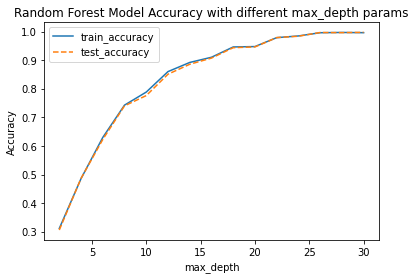

In [ ]:
# plot the train and test accuracy
display_training_curve(graph_type = 'curve',
                       model_name='Random Forest',
                       tune_param_name = 'max_depth',
                       params = depth_list,
                       train_accuracies = train_score_list,
                       test_accuracies = test_score_list)

### 5. Find the best model


*   The best model with highest accuracy of random forest will have max_depth with value 30.
*   The best model will have testing accuracy around 0.99.
*   Compare the true covid case number with predicted covid case number by this best model.    



In [ ]:
idx = np.argmax(test_score_list);
best_model = model_list[idx]
best_model_depth_param = depth_list[idx]
best_model_train_score = best_model.score(X_train, y_train)
best_model_test_score = best_model.score(X_test, y_test)
print("Best model with max_depth {}, training_accuracy {} and testing_accuracy {}.".format(
    best_model_depth_param, best_model_train_score, best_model_test_score))

Best model with max_depth 30, training_accuracy 0.9940347071583514 and testing_accuracy 0.9956616052060737.


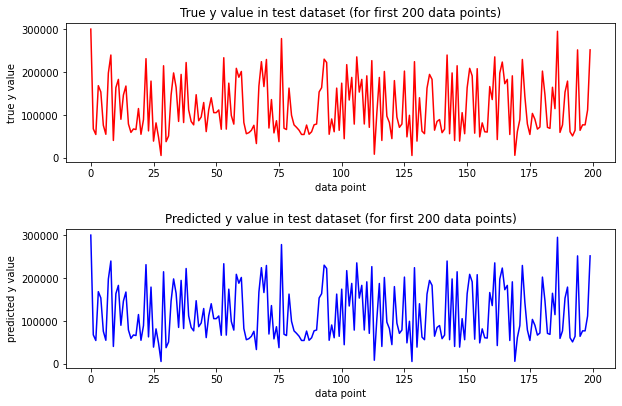

In [ ]:
y_predicted = best_model.predict(X_test)
num_data_points = 200
x_axis_label = 'data point'
compare_predicted_and_true_value(num_data_points, x_axis_label, y_test, y_predicted)
errors = y_test- y_predicted;

## Neural Network Model

### 1. Data import and preprocessing
For the neural network model, we will do the following preprocessing:
*   Drop the state column.
*   Scale X by Min-Max scalar.
*   Columns except for new_cases columns are feature columns, will be treated as X. The dimensionality of features is 50.
*   *new_cases* columns is the label that we want to predict, will be treated as y.

In [ ]:
final_df = pd.read_csv('features_and_labels.csv');
#separate labels and features
#drop the state column
train_df = final_df.drop(columns = ['state'])
y_batch = train_df.iloc[:,-1].to_numpy()
y_batch = y_batch[:, None]
train_df = train_df.iloc[:, :-1]
x_batch = train_df.to_numpy()

#min max scale the features
sc = MinMaxScaler()
x_batch=sc.fit_transform(x_batch)

print("Features shape {}".format(x_batch.shape))
print("Label shape {}".format(y_batch.shape))

Features shape (9220, 50)
Label shape (9220, 1)


### 2. Split the training data and testing data
*   80% of the data will be used for training, 20% of the data will be used for testing.
*   Convert data from numpy array to tensors

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_batch, y_batch, test_size=0.2, random_state=42)
#convert to tensors
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)
# check the training tensor and testing tensor size
print("Training Data Tensor Size: features x:{},  label y:{}".format(X_train.shape, y_train.shape))
print("Testing Data Tensor Size: features x:{},  label y:{}".format(X_test.shape, y_test.shape))

Training Data Tensor Size: features x:torch.Size([7376, 50]),  label y:torch.Size([7376, 1])
Testing Data Tensor Size: features x:torch.Size([1844, 50]),  label y:torch.Size([1844, 1])


### 3. Construct our neural network model
Our neural network structure is as follows:
*   one input linear layer
*   one relu layer
*   one hidden layer
*   one relu layer
*   one output linear layer



In [ ]:
class NN(torch.nn.Module):
    def __init__(self, features, hidden1):
        super(NN, self).__init__()
        self.linear1 = torch.nn.Linear(features, hidden1)
        self.relu1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden1, hidden1)
        self.relu2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(hidden1, 1)

    def forward(self, x):
        return self.linear3(self.relu2(self.linear2(self.relu1(self.linear1(x)))))


### 4. Model Training


*   For the optimizer, we will choose adaboost and tune the learning rate with gridsearch. We also tune the hidden features with gridsearch
*   For the loss, we choose RMSE.
*   We will train this dataset for 25000 epochs.
*   We visualize the training loss wrt. epochs for the best model




In [ ]:
#train the NN
#tune the learning rate and hidden layer via grid search
num_data, num_features = X_train.shape
criterion = nn.MSELoss()
best_lr = []
best_hidden = []
final_loss = []
best_loss_list = []
models = []
lr_list = [0.01, 0.05, 0.1, 0.2, 0.3]
hidden_list = [20, 30, 40]

for hidden in hidden_list:
  for lr in lr_list:
    model = NN(num_features, hidden)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    training_loss_list = []
    best_lr.append(lr)
    best_hidden.append(hidden)
    for i in range(25000):
        cur_epoch = i;
        optimizer.zero_grad()
        y_predicted = model(X_train.float())
        loss = torch.sqrt(criterion(y_predicted, y_train.float()))
        #last iteration, append to lists
        if (i == 24999):
          print("Final loss from hidden_layers {} and learning rate {}: [{}]".format(hidden, lr, loss))
          models.append(model)
          final_loss.append(loss)
        training_loss_list.append(loss.item());
        loss.backward()
        optimizer.step()
    best_loss_list.append(training_loss_list)

Final loss from hidden_layers 20 and learning rate 0.01: [27919.630859375]
Final loss from hidden_layers 20 and learning rate 0.05: [40036.50390625]
Final loss from hidden_layers 20 and learning rate 0.1: [41918.89453125]
Final loss from hidden_layers 20 and learning rate 0.2: [19612.0]
Final loss from hidden_layers 20 and learning rate 0.3: [20307.59375]
Final loss from hidden_layers 30 and learning rate 0.01: [18498.83203125]
Final loss from hidden_layers 30 and learning rate 0.05: [15106.0478515625]
Final loss from hidden_layers 30 and learning rate 0.1: [12929.3525390625]
Final loss from hidden_layers 30 and learning rate 0.2: [20369.689453125]
Final loss from hidden_layers 30 and learning rate 0.3: [18859.595703125]
Final loss from hidden_layers 40 and learning rate 0.01: [20926.44140625]
Final loss from hidden_layers 40 and learning rate 0.05: [19583.4375]
Final loss from hidden_layers 40 and learning rate 0.1: [19387.5234375]
Final loss from hidden_layers 40 and learning rate 0.

In [ ]:
#identify the best model through our grid search
idx = np.argmin(final_loss);
loss = final_loss(idx)
best_model = models[idx]
lr = best_lr[idx]
hidden = best_hidden[idx]
training_loss_list = best_loss_list[idx]
print("Best model with hidden layers {}, learning rate {}, and final loss {}.".format(
    hidden, lr, loss))

Best model with hidden layers 30, learning rate 0.1, and final loss 12929.3525390625.


Visualize training loss change with epochs for the best model.

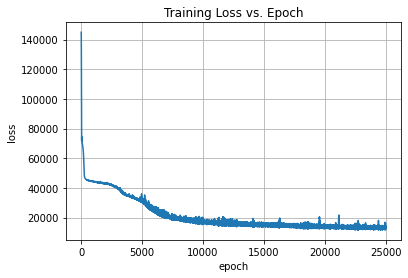

In [ ]:
# training loss vs epoch graph
epoch_list = range(0, 25000)
plt.plot(epoch_list, training_loss_list)
plt.title('Training Loss vs. Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.autoscale(enable=True, axis='x', tight=False)
plt.grid()

### 5. Model Prediction & Performance Analysis

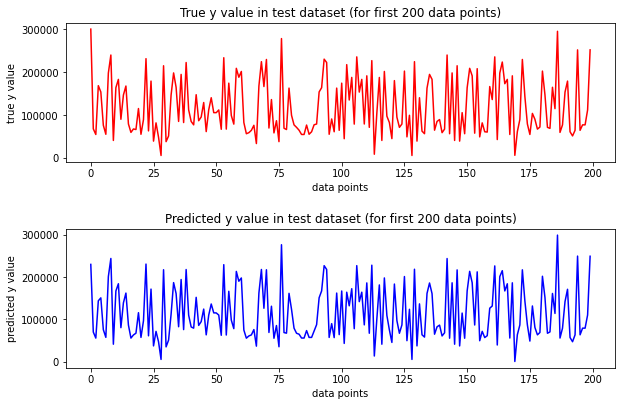

In [ ]:
predictions = best_model(X_test.float()).detach().numpy()
# visualize the true value of the testing data and the predicted data
compare_predicted_and_true_value(200,'data points', y_test, predictions)

Neural Network Model MAE: 6603.907882458734


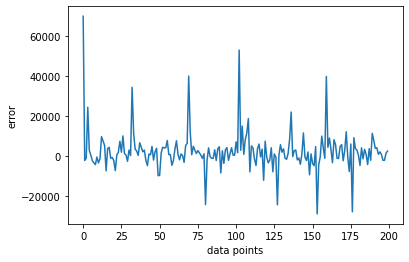

In [ ]:
errors = y_test - predictions
plt.plot(range(0,200), errors[0:200])
plt.xlabel('data points')
plt.ylabel('error')
#absolute mean error
MAE = np.average(np.abs(errors))
print("Neural Network Model MAE: {}".format(MAE))

# Model Comparison and Conclusion
*   After tuning the paramaters, performance of Lasso/Ridge regression model is improved. The best performance of Lasso/Ridge model will correspond to accuracy around 65%.
*   Our random forest will have the best performance. This could be due to several things:
<br>a. We converted state information and used PCA to remove the collinearity of features.
<br>b. The essence of random forest is to make decisions constantly and select features by importance sequentially. This may match the properties of our dataset.
*  Our neural network model is better at predicting the direction of  case counts rather than the exact value.


# Challenges and Obstacles Faced




*   Data set selection and merging: the Yelp and OpenTable data sets had slightly different features (reservation count v. reservation count relative to 2019) making it challenging to combine them into a longer time series. Moreover, the data for the overlapping period did not portray exactly the same story.
*   To aggregate or not to aggregate? We had to decide whether to synthesize tweet scores into a single daily summary statistic or to leave each tweet on its own. The former option may provide clearer signals, but the latter provides more nuisance.
*   The Twitter API has limits on the number of tweets a user can scrape at a time. Because we needed a sufficient amount of tweet data to perform modelling, we had to devise a mechanism for the API to not time out. We decided to program the API to sleep for fixed intervals to prevent this from ocurring.
*   PyTorch does not come with many tuning packages such as GridSearchCV in sklearn. Due to this, in order to tune, we had to implement our own version of GridSearch, which is perhaps not as robust as the formally implemented version.



# Potential Next Steps



*   We could develop a streaming application with Apache Storm for continuous prediction of covid cases as more data comes in every day.
*   We could try a more robust neural network, with more hidden layers and varying activation functions.
*   Since our data is implictly linked to time, we could attempt a time series analysis next.  